# Section 1: Regime-Switching Strategy Introduction

This notebook implements, backtests, and analyzes a sophisticated regime-switching trading strategy. The core of this project is a custom-built, class-based, event-driven backtester designed to handle complex, path-dependent trading logic.

**Baseline Strategy:** A simple regime model based on the VIX index.

### Strategy Goal
The primary goal is to dynamically adapt the trading strategy based on the prevailing market volatility regime. By identifying whether the market is in a "Calm" or "Panic" state, we can apply the logic best suited for that environment.

-   **Assets:** `['NVDA', 'AAPL', 'MSFT', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B']`
-   **Benchmark:** `SPY`

### Trading Logic

#### Regime 1: "Calm" (Low Volatility)
In periods of low volatility, markets tend to exhibit trending behavior. We will deploy a **Trend-Following** strategy.
-   **Logic:** Exponential Moving Average (EMA) Crossover.
-   **Go Long:** The short-term EMA (e.g., 20-period) crosses above the long-term EMA (e.g., 50-period).
-   **Exit Long:** The short-term EMA crosses below the long-term EMA.
-   **Go Short:** The short-term EMA (e.g., 20-period) crosses below the long-term EMA (e.g., 50-period).
-   **Exit Short:** The short-term EMA crosses above the long-term EMA.


#### Regime 2: "Panic" (High Volatility)
In periods of high volatility and market stress, prices often experience sharp drops followed by quick reversions. We will deploy a **Mean-Reversion** strategy to capitalize on these movements.
-   **Logic:** Bollinger Bands (e.g., 20-period, 2 standard deviations).
-   **Go Long ("Buy the Dip"):** The price touches or crosses below the Lower Bollinger Band.
-   **Exit Long ("Take Profit"):** The price reverts and touches the Middle Bollinger Band (the moving average).
-   **Go Short:** The price touches or crosses above the Upper Bollinger Band.
-   **Exit Long:** The price reverts and touches the Middle Bollinger Band (the moving average).

### Critical Rule: Regime Switch
A core rule of the strategy is to manage risk during regime transitions. When the model detects a switch from one regime to another (e.g., Calm $\rightarrow$ Panic), **all open positions established under the *old* regime's logic are immediately closed.** This prevents holding a trend-following position in a market that has just entered a panic phase, or vice-versa.

## 1. Setup and Imports

In [ ]:
# Install required packages
# %pip install pandas numpy yfinance matplotlib seaborn ta scipy tqdm -q ipywidgets
# %pip install curl_cffi
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from ta.trend import EMAIndicator 
from ta.volatility import AverageTrueRange, BollingerBands
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass, field
from enum import Enum
from datetime import datetime, timedelta
import warnings
from tqdm.notebook import tqdm
import json
import requests
import time

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ All imports successful!")


@dataclass

@dataclass
class StrategyConfig:
    """
    Strategy configuration parameters for the 
    VIX-based Regime-Switching (Calm/Panic) model.
    """

    # === Core Data & Capital ===
    train_start: str = "2010-01-01"
    train_end: str = "2019-12-31"
    initial_capital: float = 500000.0  # $500K
    transaction_cost: float = 0.0      # 0%
    leverage: float = 0.0              # No leverage

    # === Regime Parameters (VIX) ===
    vix_regime_threshold: float = 25.0  # Historical reference threshold
    vix_upper_threshold: float = 27.0   # Sharpe fix: hysteresis upper band
    vix_lower_threshold: float = 23.0   # Sharpe fix: hysteresis lower band
    regime_confirm_days: int = 2       # Sharpe fix: require sustained move before switching
    vix_smoothing_period: int = 5  # Moving average window for VIX

    # === Strategy 1: "Calm" / Trend-Following ===
    ema_fast: int = 20
    ema_slow: int = 50
    ema_spread_confirm: float = 0.003  # Sharpe fix: require >0.3% EMA separation

    # === Strategy 2: "Panic" / Mean-Reversion ===
    bb_period: int = 20
    bb_std: float = 1.5
    bb_confirm_pct: float = 0.01  # Sharpe fix: need 1% deviation from middle band

    # === Position Risk (Stops) ===
    atr_period: int = 14         # Used to calculate dynamic stop-loss
    stop_loss_pct: float = 0.02      # 2% (acts as a 'floor' for the ATR stop)
    trailing_stop_pct: float = 0.015 # 1.5% (acts as a 'floor' for the ATR stop)
    calm_stop_atr_mult: float = 2.5  # Sharpe fix: wider calm stop lets winners run
    panic_stop_atr_mult: float = 1.2 # Sharpe fix: tighter panic stop cuts losers
    calm_trailing_atr_mult: float = 2.0
    panic_trailing_atr_mult: float = 0.8
    min_atr_pct: float = 0.005

    # === Portfolio Risk (Sizing & Drawdown) ===
    max_positions: int = 10          # Max concurrent positions
    min_position_size: float = 0.02  # 2% floor to reduce sizing shocks
    max_position_size: float = 1 / max_positions  # 6% cap keeps exposures balanced
    risk_per_trade_pct: float = 0.005  # Sharpe fix: target 0.5% capital at risk per leg
    max_portfolio_drawdown: float = 0.15 # 15% (Kill-switch)
    min_signal_gap_days: int = 3      # Sharpe fix: enforce cool-down between entries


class MarketRegime(Enum):
    """Market volatility regimes based on strategy goal"""
    CALM = "calm"      # Low volatility, deploy Trend-Following
    PANIC = "panic"    # High volatility, deploy Mean-Reversion


class EventType(Enum):
    """Types of market events"""
    # Regime events
    REGIME_CHANGE = "regime_change"
    
    # Trend following events
    GOLDEN_CROSS = "golden_cross"
    DEATH_CROSS = "death_cross"
    
    # Mean reversion events
    BB_UPPER_CROSS = "bb_upper_cross"      
    BB_LOWER_CROSS = "bb_lower_cross"      
    BB_MIDDLE_CROSS_UP = "bb_middle_cross_up"    
    BB_MIDDLE_CROSS_DOWN = "bb_middle_cross_down"  
    
    # Exit events
    STOP_LOSS_HIT = "stop_loss_hit"
    TRAILING_STOP_HIT = "trailing_stop_hit"
    MAX_DRAWDOWN_HIT = "max_drawdown_hit"
    ORDER_FILLED = "order_filled"
    
    TRADE_OPEN = "trade_open"
    TRADE_CLOSE = "trade_close"


@dataclass
class Event:
    """Represents a market event"""
    timestamp: datetime
    event_type: EventType
    symbol: str
    data: Dict
    priority: int = 0
    
    def __repr__(self):
        return f"Event({self.timestamp.date()}, {self.symbol}, {self.event_type.value}, priority={self.priority})"


@dataclass
class Position:
    """Represents an open position"""
    symbol: str
    side: str  # "LONG" or "SHORT"
    entry_price: float
    entry_time: datetime
    shares: float
    stop_loss: float
    trailing_stop: float
    highest_price: float = 0.0
    lowest_price: float = float('inf')
    regime: MarketRegime = MarketRegime.CALM # Default
    margin_required: float = 0.0

    @property
    def value(self) -> float:
        """Current position value"""
        direction = 1 if self.side == 'LONG' else -1
        return self.shares * self.entry_price * direction

@dataclass
class Trade:
    """Completed trade record"""
    symbol: str
    side: str
    entry_time: datetime
    exit_time: datetime
    entry_price: float
    exit_price: float
    shares: float
    pnl: float
    pnl_pct: float
    reason: str
    regime: MarketRegime


print("✅ Configuration and data classes defined!")


def get_spy_stocks(top_n: int = 50) -> List[str]:
    """
    Get SPY constituent stocks
    For this example, we'll use the top 50 most liquid S&P 500 stocks
    """
    # Top 50 S&P 500 stocks by market cap (as of 2010-2019 period)
    spy_stocks = [
        'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'BRK.B', 'JNJ', 'JPM', 'V', 'PG', 'XOM',
        'BAC', 'MA', 'T', 'DIS', 'HD', 'INTC', 'VZ', 'PFE', 'MRK', 'CSCO',
        'KO', 'PEP', 'WFC', 'CMCSA', 'C', 'CVX', 'NFLX', 'ABT', 'ORCL', 'COST',
        'BA', 'MCD', 'IBM', 'UNH', 'PM', 'GE', 'HON', 'QCOM', 'AMGN', 'MDT',
        'UPS', 'BMY', 'SBUX', 'TXN', 'LOW', 'MMM', 'LMT', 'CAT', 'NKE', 'GS'
    ]
    return ['NVDA','AAPL', 'MSFT', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'GOOG', 'BRK-B']




def load_vix_data(config: StrategyConfig) -> pd.DataFrame:
    """
    Load and process VIX data for regime detection
    Adds hysteresis + confirmation to reduce whipsaw-induced Sharpe drag.
    """
    vix = yf.download("^VIX", 
                      start=config.train_start,
                      end=config.train_end,
                      progress=False)
    vix.index = vix.index.tz_localize(None)
    if not vix.index.is_unique:
        print("⚠️ Warning: VIX data contains duplicate index dates. Keeping first entry for each date.")
        vix = vix[~vix.index.duplicated(keep='first')]

    vix['VIX_MA'] = vix['Close'].rolling(window=config.vix_smoothing_period).mean()

    confirm_window = max(config.regime_confirm_days, 1)
    upper = config.vix_upper_threshold or config.vix_regime_threshold
    lower = config.vix_lower_threshold or config.vix_regime_threshold
    if upper <= lower:
        upper = config.vix_regime_threshold
        lower = config.vix_regime_threshold

    if confirm_window > 1:
        panic_window = vix['VIX_MA'].rolling(confirm_window).min()
        calm_window = vix['VIX_MA'].rolling(confirm_window).max()
    else:
        panic_window = vix['VIX_MA']
        calm_window = vix['VIX_MA']

    panic_trigger = (panic_window >= upper).fillna(False)
    calm_trigger = (calm_window <= lower).fillna(False)

    regimes = []
    current_regime = MarketRegime.CALM.value
    for idx in vix.index:
        if panic_trigger.loc[idx]:
            current_regime = MarketRegime.PANIC.value
        elif calm_trigger.loc[idx]:
            current_regime = MarketRegime.CALM.value
        regimes.append(current_regime)

    vix['Regime'] = regimes
    vix = vix.dropna()
    return vix

# Get stock universe
SPY_STOCKS = get_spy_stocks(50)
print(f"✅ Using {len(SPY_STOCKS)} SPY stocks:")
print(f"   {', '.join(SPY_STOCKS[:10])}...")

✅ All imports successful!
✅ Configuration and data classes defined!
✅ Using 10 SPY stocks:
   NVDA, AAPL, MSFT, AMZN, META, AVGO, GOOGL, TSLA, GOOG, BRK-B...


## 4. Technical Indicators

In [158]:
def calculate_indicators(df: pd.DataFrame, config: StrategyConfig) -> pd.DataFrame:
    """Calculate technical indicators for a stock"""
    data = pd.DataFrame(index=df.index)
    data['Close'] = df['Close']
    data['High'] = df['High']
    data['Low'] = df['Low']
    data['Volume'] = df['Volume']
    
    # EMAs
    data['EMA_Fast'] = EMAIndicator(df['Close'], window=config.ema_fast, fillna=True).ema_indicator()
    data['EMA_Slow'] = EMAIndicator(df['Close'], window=config.ema_slow, fillna=True).ema_indicator()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    
    
    # ATR
    atr = AverageTrueRange(df['High'], df['Low'], df['Close'], window=config.atr_period, fillna=True)
    data['ATR'] = atr.average_true_range()
    data['ATR_Pct'] = data['ATR'] / data['Close']  # Kept for stop-loss
    
    # Bollinger Bands
    bb = BollingerBands(df['Close'], window=config.bb_period, window_dev=config.bb_std, fillna=True)
    data['BB_Upper'] = bb.bollinger_hband()
    data['BB_Lower'] = bb.bollinger_lband()
    data['BB_Middle'] = bb.bollinger_mavg()
    
    # Drop initial NaN rows
    # SIMPLIFIED max_window calculation
    max_window = max(config.ema_slow, config.bb_period, config.atr_period)
    data = data.iloc[max_window:]
    
    return data

print("✅ SIMPLIFIED Technical indicators function defined!")

✅ SIMPLIFIED Technical indicators function defined!


## 5. Event Detector

In [159]:
class EventDetector:
    """
    Detects market events from price data.
    
    This SIMPLIFIED version only detects the core events
    for our two strategies: EMA crosses and BB crosses.
    """
    
    def __init__(self, config: StrategyConfig):
        self.config = config
        self.previous_state = {}
        


    def detect_trend_following_events(self, symbol: str, current_data: pd.Series, prev_data: pd.Series,
                                   timestamp: datetime) -> List[Event]:
        """Detect TREND-FOLLOWING events (EMA Crossover)"""
        events = []
        price = current_data['Close']
        ema_fast = current_data['EMA_Fast']
        ema_slow = current_data['EMA_Slow']
        spread = (ema_fast - ema_slow) / max(ema_slow, 1e-6)
        price_above_sma = price > current_data.get('SMA_200', price)
        price_below_sma = price < current_data.get('SMA_200', price)
        spread_ok = abs(spread) >= self.config.ema_spread_confirm
        # Sharpe fix: only fire trend trades when the move is meaningful and aligned with the 200SMA.
        if (ema_fast > ema_slow and prev_data['EMA_Fast'] <= prev_data['EMA_Slow'] and
                price_above_sma and spread_ok):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.GOLDEN_CROSS,
                symbol=symbol,
                data={'price': price},
                priority=10
            ))

        if (ema_fast < ema_slow and prev_data['EMA_Fast'] >= prev_data['EMA_Slow'] and
                price_below_sma and spread_ok):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.DEATH_CROSS,
                symbol=symbol,
                data={'price': price},
                priority=10
            ))

        return events

    def detect_mean_reversion_events(self, symbol: str, current_data: pd.Series, prev_data: pd.Series,
                          timestamp: datetime) -> List[Event]:
        """Detect MEAN-REVERSION events (Bollinger Bands)"""
        events = []
        price = current_data['Close']
        bb_middle = current_data['BB_Middle']
        deviation = (price - bb_middle) / max(bb_middle, 1e-6)
        atr_pct = current_data.get('ATR_Pct', self.config.min_atr_pct)
        band_confirm = abs(deviation) >= self.config.bb_confirm_pct
        atr_ok = atr_pct >= self.config.min_atr_pct
        # Sharpe fix: require sufficient distance from the middle band plus minimum volatility.
        if (price > current_data['BB_Upper'] and prev_data['Close'] <= prev_data['BB_Upper'] and
                deviation > 0 and band_confirm and atr_ok):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_UPPER_CROSS,
                symbol=symbol,
                data={'price': price, 'bb_upper': current_data['BB_Upper']},
                priority=8
            ))

        if (price < current_data['BB_Lower'] and prev_data['Close'] >= prev_data['BB_Lower'] and
                deviation < 0 and band_confirm and atr_ok):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_LOWER_CROSS,
                symbol=symbol,
                data={'price': price, 'bb_lower': current_data['BB_Lower']},
                priority=8
            ))

        if (price > bb_middle and prev_data['Close'] <= prev_data['BB_Middle']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_MIDDLE_CROSS_UP,
                symbol=symbol,
                data={'price': price, 'bb_middle': bb_middle},
                priority=7
            ))

        if (price < bb_middle and prev_data['Close'] >= prev_data['BB_Middle']):
            events.append(Event(
                timestamp=timestamp,
                event_type=EventType.BB_MIDDLE_CROSS_DOWN,
                symbol=symbol,
                data={'price': price, 'bb_middle': bb_middle},
                priority=7
            ))

        return events
    def detect_regime_change(self, symbol: str, current_regime: MarketRegime, 
                           prev_regime: MarketRegime, timestamp: datetime) -> Optional[Event]:
        """Detect changes in market regime"""
        if current_regime != prev_regime:
            return Event(
                timestamp=timestamp,
                event_type=EventType.REGIME_CHANGE,
                symbol=symbol,
                data={'new_regime': current_regime.value, 'old_regime': prev_regime.value},
                priority=10  
            )
        return None
    
    def detect_events(self, symbol: str, current_data: pd.Series, prev_data: Optional[pd.Series],
                     current_regime: MarketRegime, prev_regime: MarketRegime) -> List[Event]:
        """
        Detect all events for a symbol at current timestamp
        """
        events = []
        
        if prev_data is None:
            return events
        
        timestamp = current_data.name
        
        # Check for regime change first
        regime_event = self.detect_regime_change(symbol, current_regime, prev_regime, timestamp)
        if regime_event:
            events.append(regime_event)
        
        # 1. Detect Trend-Following (EMA) events
        events.extend(self.detect_trend_following_events(symbol, current_data, prev_data, timestamp))
        
        # 2. Detect Mean-Reversion (BB) events
        events.extend(self.detect_mean_reversion_events(symbol, current_data, prev_data, timestamp))
        
        
        return events

print("✅ SIMPLIFIED Event detector class defined!")

✅ SIMPLIFIED Event detector class defined!


## 6. Portfolio Event-Driven Backtester

In [160]:
class PortfolioBacktester:
    """
    Event-driven portfolio backtester
    Tracks daily capital changes and generates performance metrics
    
    --- SIMPLIFIED VERSION ---
    - No dynamic/regime-based sizing or stops
    - No filter logic (RSI, ADX, BBW)
    - No special profit targets
    - No regime-change failsafes
    """
    

    def __init__(self, config: StrategyConfig, stock_data: Dict[str, pd.DataFrame],
                 vix_data: pd.DataFrame, benchmark_data: Optional[pd.DataFrame] = None):
        self.config = config
        self.stock_data = stock_data
        self.symbols = list(stock_data.keys())
        self.vix_data = vix_data
        self.benchmark_data = benchmark_data

        self.capital = config.initial_capital
        self.reserve_cash = 0.0
        self.initial_capital = config.initial_capital
        self.positions: Dict[str, Position] = {}
        self.trades: List[Trade] = []
        self.event_log: List[Event] = []

        self.daily_capital: List[Dict] = []
        self.daily_positions: List[Dict] = []
        self.current_portfolio_value = config.initial_capital
        self.current_regime = MarketRegime.CALM

        self.trading_dates = self.vix_data.index
        self.event_detector = EventDetector(config)
        self.previous_data: Dict[str, pd.Series] = {}
        self.last_entry_timestamp: Dict[str, datetime] = {}




    
    def get_market_regime(self, date: datetime) -> MarketRegime:
        """Get the market regime for a given date based on VIX"""
        if date in self.vix_data.index:
            regime_value = self.vix_data.loc[date, 'Regime']
            try:
                return MarketRegime(regime_value)
            except ValueError:
                pass
        return self.current_regime

    def calculate_position_size(self, price: float, atr_pct: float) -> float:
        """
        Volatility-aware position sizing that keeps per-trade risk constant.
        """
        capital_per_trade = self.current_portfolio_value / self.config.max_positions
        max_capital_to_allocate = self.current_portfolio_value * self.config.max_position_size
        capital_to_allocate = min(capital_per_trade, max_capital_to_allocate)
        capital_to_allocate = min(capital_to_allocate, self.capital)

        atr_pct = max(atr_pct, self.config.min_atr_pct)
        risk_budget = self.current_portfolio_value * self.config.risk_per_trade_pct
        if atr_pct > 0:
            capital_to_allocate = min(capital_to_allocate, risk_budget / atr_pct)

        min_capital_to_allocate = self.current_portfolio_value * self.config.min_position_size
        if price == 0 or capital_to_allocate < min_capital_to_allocate:
            return 0
        return capital_to_allocate / price

    def calculate_stop_levels(self, price: float, atr_pct: float, side: str = 'LONG',
                             regime: Optional[MarketRegime] = None) -> Tuple[float, float]:
        """Calculate stop loss and trailing stop levels."""
        atr_pct = max(atr_pct, self.config.min_atr_pct)
        if regime == MarketRegime.PANIC:
            stop_mult = self.config.panic_stop_atr_mult
            trail_mult = self.config.panic_trailing_atr_mult
        else:
            stop_mult = self.config.calm_stop_atr_mult
            trail_mult = self.config.calm_trailing_atr_mult

        stop_distance = max(atr_pct * stop_mult, self.config.stop_loss_pct)
        trailing_distance = max(atr_pct * trail_mult, self.config.trailing_stop_pct)
        if side == 'SHORT':
            stop_loss = price * (1 + stop_distance)
            trailing_stop = price * (1 + trailing_distance)
        else:
            stop_loss = price * (1 - stop_distance)
            trailing_stop = price * (1 - trailing_distance)
        return stop_loss, trailing_stop

    def open_position(self, symbol: str, price: float, timestamp: datetime, atr_pct: float, side: str = 'LONG'):
        """Open a new position (long or short)."""
        current_regime = self.get_market_regime(timestamp)
        cooldown = getattr(self.config, 'min_signal_gap_days', 0)
        # Sharpe fix: enforce a cool-down window per symbol to trim noise.
        last_entry = self.last_entry_timestamp.get(symbol)
        if cooldown and last_entry is not None:
            delta_days = (timestamp - last_entry).days
            if delta_days < cooldown:
                return

        atr_pct = max(atr_pct, self.config.min_atr_pct)
        shares = self.calculate_position_size(price, atr_pct)
        if shares <= 0:
            return

        position_cost = shares * price
        fee = position_cost * self.config.transaction_cost
        stop_loss, trailing_stop = self.calculate_stop_levels(price, atr_pct, side, current_regime)

        ev_open = Event(
            timestamp=timestamp,
            event_type=EventType.TRADE_OPEN,
            symbol=symbol,
            data={'intent_side': side, 'price': price, 'shares': shares},
            priority=9
        )
        self.event_log.append(ev_open)

        if side == 'LONG':
            total_cost = position_cost + fee
            if total_cost > self.capital or shares <= 0:
                return
            self.capital -= total_cost
            pos = Position(
                symbol=symbol,
                side='LONG',
                entry_price=price,
                entry_time=timestamp,
                shares=shares,
                stop_loss=stop_loss,
                trailing_stop=trailing_stop,
                highest_price=price,
                lowest_price=price,
                regime=current_regime,
                margin_required=0.0
            )
            self.positions[symbol] = pos
        else:
            proceeds = position_cost
            margin_rate = getattr(self.config, 'short_initial_margin_pct', 0.5)
            margin_required = position_cost * margin_rate
            self.capital += (proceeds - fee)
            if self.capital < margin_required or shares <= 0:
                self.capital -= (proceeds - fee)
                return
            self.capital -= margin_required
            if not hasattr(self, 'reserved_cash'):
                self.reserved_cash = 0.0
            self.reserved_cash += margin_required
            pos = Position(
                symbol=symbol,
                side='SHORT',
                entry_price=price,
                entry_time=timestamp,
                shares=shares,
                stop_loss=stop_loss,
                trailing_stop=trailing_stop,
                highest_price=price,
                lowest_price=price,
                regime=current_regime,
                margin_required=margin_required
            )
            self.positions[symbol] = pos

        self.last_entry_timestamp[symbol] = timestamp
    def close_position(self, symbol: str, price: float, timestamp: datetime, reason: str = "Exit"):
        """Close an open position and update cash, trades and logs."""
        if symbol not in self.positions:
            return

        pos = self.positions[symbol]
        shares = pos.shares
        entry_price = pos.entry_price
        side = pos.side

        trade_notional = price * shares
        fee = trade_notional * self.config.transaction_cost

        if side == 'LONG':
            # Sell the long position: receive proceeds minus fee
            proceeds = trade_notional - fee
            # Realized P&L
            pnl = (price - entry_price) * shares  # approximate net fees baseline
            # Add proceeds back to available cash
            self.capital += proceeds

        else:  # SHORT
            # Realized P&L for short: (entry - exit) * shares
            pnl = (entry_price - price) * shares
            margin = pos.margin_required if hasattr(pos, 'margin_required') else 0.0

            # Pay to buy back the borrowed shares and pay close fee
            self.capital -= (trade_notional + fee)

            # Release the reserved margin back to available capital
            if not hasattr(self, 'reserved_cash'):
                self.reserved_cash = 0.0
            self.reserved_cash = max(0.0, self.reserved_cash - margin)
            self.capital += margin
     

        # Build Trade record in the expected format used by your metrics function
        # pnl_pct is measured vs entry notional
        entry_notional = entry_price * shares if entry_price * shares != 0 else 1.0
        pnl_pct = pnl / entry_notional

        trade_record = Trade(
            symbol=symbol,
            side=side,
            entry_price=entry_price,
            exit_price=price,
            entry_time=pos.entry_time,
            exit_time=timestamp,
            shares=shares,
            pnl=pnl,
            pnl_pct=pnl_pct,
            reason=reason,
            regime=pos.regime
        )
        self.trades.append(trade_record)

        # Log event
        ev = Event(
            timestamp=timestamp,
            event_type=EventType.TRADE_CLOSE,
            symbol=symbol,
            data={'price': price, 'reason': reason, 'pnl': pnl},
            priority=9
        )
        self.event_log.append(ev)

        # remove position
        del self.positions[symbol]

    

    def _update_trailing_for_position(self, pos: Position, current_price: float):
        """Update trailing stop in-place for a position based on new price and the trailing distance at open."""
        if pos.entry_price == 0:
            return

        # compute trailing_pct based on stored trailing_stop relative to entry price
        if pos.side == 'LONG':
            trailing_pct = 1.0 - (pos.trailing_stop / pos.entry_price)
            if current_price > pos.highest_price:
                pos.highest_price = current_price
                candidate = pos.highest_price * (1.0 - trailing_pct)
                # trailing stop only moves up (take max)
                pos.trailing_stop = max(pos.trailing_stop, candidate)
        else:  # SHORT
            trailing_pct = (pos.trailing_stop / pos.entry_price) - 1.0
            if current_price < pos.lowest_price:
                pos.lowest_price = current_price
                candidate = pos.lowest_price * (1.0 + trailing_pct)
                # trailing stop only moves down for short (take min)
                pos.trailing_stop = min(pos.trailing_stop, candidate)


    def check_stops(self, symbol: str, current_price: float, timestamp: datetime):
        """Check stop loss and trailing stop for a position and close if hit."""
        if symbol not in self.positions:
            return

        pos = self.positions[symbol]
        side = pos.side

        # Update trailing stop before evaluating triggers
        self._update_trailing_for_position(pos, current_price)

        hit = False
        reason = None

        if side == 'LONG':
            if current_price <= pos.stop_loss:
                hit = True
                reason = 'Stop Loss'
            elif current_price <= pos.trailing_stop:
                hit = True
                reason = 'Trailing Stop'
        else:  # SHORT
            if current_price >= pos.stop_loss:
                hit = True
                reason = 'Stop Loss'
            elif current_price >= pos.trailing_stop:
                hit = True
                reason = 'Trailing Stop'

        if hit:
            self.close_position(symbol, current_price, timestamp, reason)



    def calculate_portfolio_(self, date: datetime) -> float:
        """Correct mark-to-market portfolio equity calculation."""
        total = self.capital
        reserved = getattr(self, 'reserved_cash', 0.0)
        total += reserved
        long_total = 0.0
        short_total = 0.0
        for symbol, pos in self.positions.items():
            try:
                price = self.stock_data[symbol].loc[date]['Close']
            except Exception:
                price = pos.entry_price
            if pos.side == 'LONG':
                long_total += pos.shares * price
            else:
                short_total += pos.shares * price
        equity = total + long_total - short_total
        return equity
    def handle_event(self, event: Event):
        """Route and process incoming events. Logs events, handles regime change and dispatches to strategy handlers."""
        # Append to event log
        self.event_log.append(event)

        # Regime change handling
        if event.event_type == EventType.REGIME_CHANGE:
            new_regime = MarketRegime(event.data['new_regime'])
            old_regime = MarketRegime(event.data['old_regime'])
            self.current_regime = new_regime

            # Close positions that were opened under the old regime
            for sym in list(self.positions.keys()):
                pos = self.positions.get(sym)
                if pos is None:
                    continue
                if pos.regime != new_regime:
                    # attempt to use today's close; fallback to entry price
                    try:
                        price = self.stock_data[sym].loc[event.timestamp]['Close']
                    except Exception:
                        price = pos.entry_price
                    self.close_position(sym, price, event.timestamp, 'Regime Change')
            return

        # Dispatch mean-reversion events
        if event.event_type in {
            EventType.BB_LOWER_CROSS,
            EventType.BB_UPPER_CROSS,
            EventType.BB_MIDDLE_CROSS_UP,
            EventType.BB_MIDDLE_CROSS_DOWN
        }:
            if event.symbol in self.stock_data and event.timestamp in self.stock_data[event.symbol].index:
                current_data = self.stock_data[event.symbol].loc[event.timestamp]
            else:
                current_data = pd.Series({'Close': event.data.get('price'), 'ATR_Pct': getattr(self.config, 'default_atr_pct', 0.02)})
            self.handle_mean_reversion_events(event, current_data)
            return

        # Dispatch trend events
        if event.event_type in {EventType.GOLDEN_CROSS, EventType.DEATH_CROSS}:
            if event.symbol in self.stock_data and event.timestamp in self.stock_data[event.symbol].index:
                current_data = self.stock_data[event.symbol].loc[event.timestamp]
            else:
                current_data = pd.Series({'Close': event.data.get('price'), 'ATR_Pct': getattr(self.config, 'default_atr_pct', 0.02)})
            self.handle_trend_following_events(event, current_data)
            return

        # Unhandled events are logged but ignored for now
        return

    def can_open_position(self) -> bool:
        """Check if we can open a new position"""
        return len(self.positions) < self.config.max_positions
    
        

    def handle_mean_reversion_events(self, event: Event, current_data: pd.Series):
        """Handle mean reversion strategy events for both LONG and SHORT logic."""
        if self.current_regime != MarketRegime.PANIC:
        # Sharpe fix: only use mean-reversion logic when volatility is elevated.
            return
        symbol = event.symbol
        price = event.data['price']
        atr_pct = float(current_data.get('ATR_Pct', getattr(self.config, 'default_atr_pct', 0.02)))
        atr_pct = max(atr_pct, self.config.min_atr_pct)
        if event.event_type == EventType.BB_LOWER_CROSS:
            if symbol in self.positions and self.positions[symbol].side == 'LONG':
                return
            if symbol in self.positions and self.positions[symbol].side == 'SHORT':
                self.close_position(symbol, price, event.timestamp, 'Reverse to LONG - Lower Band')
            if self.can_open_position():
                self.open_position(symbol, price, event.timestamp, atr_pct, side='LONG')
        elif event.event_type == EventType.BB_UPPER_CROSS:
            if symbol in self.positions and self.positions[symbol].side == 'SHORT':
                return
            if symbol in self.positions and self.positions[symbol].side == 'LONG':
                self.close_position(symbol, price, event.timestamp, 'Reverse to SHORT - Upper Band')
            if self.can_open_position():
                self.open_position(symbol, price, event.timestamp, atr_pct, side='SHORT')
        elif event.event_type == EventType.BB_MIDDLE_CROSS_UP:
            if symbol in self.positions:
                pos = self.positions[symbol]
                if pos.side == 'LONG':
                    self.close_position(symbol, price, event.timestamp, 'Exit LONG - Middle Band')
                elif pos.side == 'SHORT':
                    self.close_position(symbol, price, event.timestamp, 'Cover SHORT - Middle Band')
        elif event.event_type == EventType.BB_MIDDLE_CROSS_DOWN:
            if symbol in self.positions:
                pos = self.positions[symbol]
                if pos.side == 'SHORT':
                    self.close_position(symbol, price, event.timestamp, 'Exit SHORT - Middle Band')
                elif pos.side == 'LONG':
                    self.close_position(symbol, price, event.timestamp, 'Exit LONG - Middle Band')

    def handle_trend_following_events(self, event: Event, current_data: pd.Series):
        """Handle trend following strategy events (long & short)"""
        if self.current_regime != MarketRegime.CALM:
        # Sharpe fix: keep trend trades in calm regimes only.
            return
        symbol = event.symbol
        atr_pct = float(current_data.get('ATR_Pct', getattr(self.config, 'default_atr_pct', 0.02)))
        atr_pct = max(atr_pct, self.config.min_atr_pct)
        if event.event_type == EventType.GOLDEN_CROSS:
            if symbol in self.positions and self.positions[symbol].side == 'SHORT':
                self.close_position(symbol, event.data['price'], event.timestamp, "Cover - Golden Cross")
            if symbol not in self.positions and self.can_open_position():
                self.open_position(symbol, event.data['price'], event.timestamp, atr_pct, side='LONG')
        elif event.event_type == EventType.DEATH_CROSS:
            if symbol in self.positions and self.positions[symbol].side == 'LONG':
                self.close_position(symbol, event.data['price'], event.timestamp, "Exit - Death Cross")
            if symbol not in self.positions and self.can_open_position():
                self.open_position(symbol, event.data['price'], event.timestamp, atr_pct, side='SHORT')
    
    def run(self):
        """Run the backtest"""
        print(f"\n{'='*60}")
        print("SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST")
        print(f"{'='*60}")
        print(f"Period: {self.config.train_start} to {self.config.train_end}")
        print(f"Universe: {len(self.symbols)} stocks")
        print(f"Initial Capital: ${self.initial_capital:,.0f}")
        print(f"{'='*60}\n")
        
        # Initialize previous regime
        prev_regime = self.get_market_regime(self.trading_dates[0])
        self.current_regime = prev_regime # Ensure current_regime is set
        
        # Process each trading day
        for date in tqdm(self.trading_dates, desc="Processing days"):
            # Get current regime
            current_regime = self.get_market_regime(date)
            
            day_events = []
            
            # Check for regime change
            if current_regime != prev_regime:
                regime_event = Event(
                    timestamp=date,
                    event_type=EventType.REGIME_CHANGE,
                    symbol="MARKET", # Using "MARKET" is good practice
                    data={'new_regime': current_regime.value, 'old_regime': prev_regime.value},
                    priority=10
                )
                day_events.append(regime_event)
            
            for symbol in self.symbols:
                if date not in self.stock_data[symbol].index:
                    continue
                
                current_data = self.stock_data[symbol].loc[date]
                prev_data = self.previous_data.get(symbol)
                
                # Detect events
                if prev_data is not None: # Ensure we have previous data to detect events
                    events = self.event_detector.detect_events(symbol, current_data, prev_data,
                                                            current_regime, prev_regime)
                    day_events.extend(events)
                
                # --- DAILY CHECKS ---
                # Check stops (for open positions)
                self.check_stops(symbol, current_data['Close'], date)
                
                
                # Update previous data
                self.previous_data[symbol] = current_data
            
            # Sort events by priority
            day_events.sort(key=lambda e: e.priority, reverse=True)
            
            # Handle all events
            for event in day_events:
                self.handle_event(event)
            
  
            # --- INSTRUMENTATION: sanity checks & debug prints ---
            portfolio_value = self.calculate_portfolio_(date)
            self.current_portfolio_value = portfolio_value

            # Sanity checks:
            # 1) detect enormous jumps
            if len(self.daily_capital) > 0:
                prev = self.daily_capital[-1]['portfolio_value']
            else:
                prev = self.initial_capital

            # Thresholds you can tweak:
            if portfolio_value <= 0 or portfolio_value > prev * 100 or np.isnan(portfolio_value) or np.isinf(portfolio_value):
                print("\n⚠️  SANITY ALERT on date:", date)
                print(f"  portfolio_value: {portfolio_value:,}")
                print(f"  prev_portfolio_value: {prev:,}")
                print(f"  available capital (self.capital): {self.capital:,}")
                print(f"  reserved_cash: {getattr(self, 'reserved_cash', 0.0):,}")
                # compute long_total and short_total exactly as calculate_portfolio_ does
                long_total = 0.0
                short_total = 0.0
                for sym, p in self.positions.items():
                    try:
                        px = self.stock_data[sym].loc[date]['Close']
                    except Exception:
                        px = p.entry_price
                    if p.side == 'LONG':
                        long_total += p.shares * px
                    else:
                        short_total += p.shares * px
                    print(f"   pos: {sym} side={p.side} shares={p.shares:.6f} entry={p.entry_price:.2f} price={px:.2f} margin={p.margin_required:.2f}")
                print(f"  long_total: {long_total:,}")
                print(f"  short_total: {short_total:,}")
                print(f"  computed equity components => capital + reserved + longs - shorts = "
                    f"{self.capital + getattr(self,'reserved_cash',0.0) + long_total - short_total:,}")
                # Print top 10 trades for context
                print("  Most recent trades (last 10):")
                for t in self.trades[-10:]:
                    print(f"    {t.symbol} {t.side} entry={t.entry_price:.2f} exit={t.exit_price:.2f} pnl={t.pnl:.2f} shares={t.shares:.2f}")
                # raise or break to stop expensive backtest if desired
                # raise RuntimeError("Sanity check failed - inspect printed accounting above")
            # --- END INSTRUMENTATION ---

            
            self.daily_capital.append({
                'date': date,
                'capital': self.capital,
                'portfolio_value': portfolio_value,
                'num_positions': len(self.positions),
                'invested': portfolio_value - self.capital,
                'regime': current_regime.value
            })
            
            # Update previous regime
            prev_regime = current_regime
        
        print(f"\n{'='*60}")
        print("BACKTEST COMPLETE")
        print(f"{'='*60}")
        print(f"Total Events: {len(self.event_log)}")
        print(f"Total Trades: {len(self.trades)}")
        final_value = self.daily_capital[-1]['portfolio_value']
        print(f"Final Portfolio Value: ${final_value:,.2f}")
        print(f"Total Return: {(final_value / self.initial_capital - 1) * 100:.2f}%")
        print(f"{'='*60}\n")



## 7. Performance Metrics Calculator

In [161]:
def calculate_portfolio_metrics(backtester: PortfolioBacktester, spy_data: Optional[pd.DataFrame] = None) -> Dict:
    """Calculate comprehensive portfolio performance metrics"""
    
    # Convert to DataFrame
    df = pd.DataFrame(backtester.daily_capital)
    if df.empty:
        print("⚠️ No daily capital data found. Cannot calculate metrics.")
        return {}
    
    df.set_index('date', inplace=True)
    
    # Add regime information
    df['regime'] = df.index.map(lambda x: backtester.get_market_regime(x).value)
    
    # Calculate returns
    df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
    df['cumulative_return'] = (df['portfolio_value'] / backtester.initial_capital) - 1
    
    # Drawdown
    df['peak'] = df['portfolio_value'].cummax()
    df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']
    
    # --- Overall Metrics ---
    total_return = (df['portfolio_value'].iloc[-1] / backtester.initial_capital) - 1
    n_days = len(df)
    n_years = n_days / 252
    
    annualized_return = 0.0
    if n_years > 0:
        annualized_return = (1 + total_return) ** (1 / n_years) - 1
        
    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    max_drawdown = df['drawdown'].min()
    
    # Downside risk for Sortino
    downside_returns = df[df['daily_return'] < 0]['daily_return']
    downside_std = downside_returns.std() * np.sqrt(252)
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0
    
    # Calmar Ratio
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0
    
    # --- Overall Trade Statistics ---
    trades_df = pd.DataFrame([{
        'symbol': t.symbol,
        'pnl': t.pnl,
        'pnl_pct': t.pnl_pct,
        'reason': t.reason,
        'regime': t.regime.value
    } for t in backtester.trades])
    
    total_trades = 0
    win_rate = 0.0
    profit_factor = 0.0
    avg_win_pct = 0.0
    avg_loss_pct = 0.0
    
    if len(trades_df) > 0:
        total_trades = len(trades_df)
        wins = trades_df[trades_df['pnl'] > 0]
        losses = trades_df[trades_df['pnl'] < 0]
        
        win_rate = len(wins) / total_trades if total_trades > 0 else 0.0
        avg_win_pct = wins['pnl_pct'].mean() if len(wins) > 0 else 0.0
        avg_loss_pct = losses['pnl_pct'].mean() if len(losses) > 0 else 0.0
        
        total_profit = wins['pnl'].sum()
        total_loss = abs(losses['pnl'].sum())
        profit_factor = total_profit / total_loss if total_loss > 0 else float('inf')

    
    # --- Regime-specific Performance ---
    regime_metrics = {}
    for regime in MarketRegime:
        regime_data = df[df['regime'] == regime.value]
        if len(regime_data) > 0:
            regime_return = regime_data['daily_return'].mean() * 252  # Annualized
            regime_vol = regime_data['daily_return'].std() * np.sqrt(252)
            regime_sharpe = regime_return / regime_vol if regime_vol > 0 else 0
            regime_drawdown = regime_data['drawdown'].min()
            
            regime_metrics[regime.value] = {
                'days': len(regime_data),
                'annualized_return': regime_return,
                'annualized_vol': regime_vol,
                'sharpe_ratio': regime_sharpe,
                'max_drawdown': regime_drawdown,
                'pct_time': len(regime_data) / len(df) * 100
            }
    
    # --- Regime-specific Trade Stats ---
    regime_trade_stats = {}
    if len(trades_df) > 0:
        for regime in MarketRegime:
            regime_trades = trades_df[trades_df['regime'] == regime.value]
            if len(regime_trades) > 0:
                r_win_rate = (regime_trades['pnl'] > 0).sum() / len(regime_trades)
                r_avg_win = regime_trades[regime_trades['pnl'] > 0]['pnl_pct'].mean() if (regime_trades['pnl'] > 0).any() else 0
                r_avg_loss = regime_trades[regime_trades['pnl'] < 0]['pnl_pct'].mean() if (regime_trades['pnl'] < 0).any() else 0
                r_profit_factor = abs(regime_trades[regime_trades['pnl'] > 0]['pnl'].sum() / 
                                 regime_trades[regime_trades['pnl'] < 0]['pnl'].sum()) if (regime_trades['pnl'] < 0).any() else float('inf')
                
                regime_trade_stats[regime.value] = {
                    'total_trades': len(regime_trades),
                    'win_rate': r_win_rate,
                    'avg_win': r_avg_win,
                    'avg_loss': r_avg_loss,
                    'profit_factor': r_profit_factor
                }
    
    # --- START OF ADDED SECTION: BENCHMARK METRICS ---
    benchmark_metrics = {}
    if spy_data is not None:
        try:
            # Align benchmark data to our backtest dates
            bench_df = spy_data[['Close']].reindex(df.index).fillna(method='ffill')
            bench_df = bench_df.rename(columns={'Close': 'benchmark_close'})
            
            # Calculate benchmark portfolio value (buy-and-hold)
            bench_df['daily_return'] = bench_df['benchmark_close'].pct_change().fillna(0)
            bench_df['benchmark_value'] = backtester.initial_capital * (1 + bench_df['daily_return']).cumprod()
            
            # Add to the main daily_data df for plotting
            df['benchmark_value'] = bench_df['benchmark_value']

            # Calculate benchmark summary stats
            b_total_return = (bench_df['benchmark_value'].iloc[-1] / bench_df['benchmark_value'].iloc[0]) - 1
            b_annualized_return = (1 + b_total_return) ** (1 / n_years) - 1 if n_years > 0 else 0.0
            
            b_daily_vol = bench_df['daily_return'].std()
            b_annualized_vol = b_daily_vol * np.sqrt(252)
            b_sharpe_ratio = b_annualized_return / b_annualized_vol if b_annualized_vol > 0 else 0
            
            b_peak = bench_df['benchmark_value'].cummax()
            b_drawdown = (bench_df['benchmark_value'] - b_peak) / b_peak
            b_max_drawdown = b_drawdown.min()

            benchmark_metrics = {
                'total_return': b_total_return,
                'annualized_return': b_annualized_return,
                'annualized_volatility': b_annualized_vol,
                'sharpe_ratio': b_sharpe_ratio,
                'max_drawdown': b_max_drawdown,
                'final_value': bench_df['benchmark_value'].iloc[-1]
            }
        except Exception as e:
            print(f"⚠️ Failed to calculate benchmark metrics: {e}")
            benchmark_metrics = {} # Ensure it's an empty dict
    # --- END OF ADDED SECTION ---
    # --- Compile final dictionary ---
    return {
        'overall': {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'annualized_volatility': annualized_vol,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,  # <-- ADDED
            'calmar_ratio': calmar_ratio,    # <-- ADDED
            'max_drawdown': max_drawdown,
            'total_trades': total_trades,    # <-- ADDED
            'win_rate': win_rate,            # <-- ADDED
            'profit_factor': profit_factor,  # <-- ADDED
            'avg_win_pct': avg_win_pct,      # <-- ADDED
            'avg_loss_pct': avg_loss_pct,    # <-- ADDED
            'total_events': len(backtester.event_log),
            'final_value': df['portfolio_value'].iloc[-1]
        },
        'regime_metrics': regime_metrics,
        'benchmark': benchmark_metrics,
        'regime_trade_stats': regime_trade_stats,
        'daily_data': df
    }

## 8. Visualization Functions

In [162]:
def plot_portfolio_performance(metrics: Dict):
    """Plot comprehensive portfolio performance"""
    
    df = metrics['daily_data']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Portfolio Value
    axes[0].plot(df.index, df['portfolio_value'], label='Portfolio Value', color='green', linewidth=2)
    axes[0].axhline(y=df['portfolio_value'].iloc[0], color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    # --- START OF ADDED SECTION ---
    if 'benchmark_value' in df.columns:
        axes[0].plot(df.index, df['benchmark_value'], 
                     label='SPY Benchmark', 
                     color='gray', 
                     linestyle='--', 
                     linewidth=2,
                     alpha=0.8)
    # --- END OF ADDED SECTION ---
    axes[0].set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Portfolio Value ($)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
    
    # 2. Drawdown
    axes[1].fill_between(df.index, 0, df['drawdown'] * 100, color='red', alpha=0.3)
    axes[1].axhline(y=-15, color='darkred', linestyle='--', linewidth=2, label='15% Kill Switch')
    axes[1].set_title('Portfolio Drawdown', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Drawdown (%)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Number of Positions
    axes[2].plot(df.index, df['num_positions'], label='Active Positions', color='purple', linewidth=2)
    axes[2].fill_between(df.index, 0, df['num_positions'], alpha=0.3, color='purple')
    axes[2].set_title('Number of Active Positions', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Positions')
    axes[2].set_xlabel('Date')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_performance_summary(metrics: Dict):
    """Print formatted performance summary"""
    
    if not metrics or 'overall' not in metrics or not metrics['overall']:
        print("No metrics to display.")
        return
        
    overall = metrics['overall']
    benchmark = metrics.get('benchmark') # Use .get() to safely check if it exists
    
    print(f"\n{'='*80}")
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print(f"{'='*80}\n")
    
    # Check if benchmark data is available
    if benchmark:
        print(f"{'Metric':<30} {'Strategy':>20} {'Benchmark (SPY)':>20}")
        print(f"{'-'*30:<30} {'-'*20:>20} {'-'*20:>20}")

        print("\nReturns:")
        print(f"{'Total Return':<30} {overall['total_return']*100:>19.2f}% {benchmark['total_return']*100:>19.2f}%")
        print(f"{'Annualized Return':<30} {overall['annualized_return']*100:>19.2f}% {benchmark['annualized_return']*100:>19.2f}%")
        print(f"{'Final Portfolio Value':<30} ${overall['final_value']:>19,.0f} ${benchmark['final_value']:>19,.0f}")
        
        print(f"\nRisk Metrics:")
        print(f"{'Annualized Volatility':<30} {overall['annualized_volatility']*100:>19.2f}% {benchmark['annualized_volatility']*100:>19.2f}%")
        print(f"{'Maximum Drawdown':<30} {overall['max_drawdown']*100:>19.2f}% {benchmark['max_drawdown']*100:>19.2f}%")
        
        print(f"\nRisk-Adjusted Returns:")
        print(f"{'Sharpe Ratio':<30} {overall['sharpe_ratio']:>20.2f} {benchmark['sharpe_ratio']:>20.2f}")
        print(f"{'Sortino Ratio':<30} {overall['sortino_ratio']:>20.2f} {'N/A':>20}")
        print(f"{'Calmar Ratio':<30} {overall['calmar_ratio']:>20.2f} {'N/A':>20}")
        
        print(f"\nTrading Statistics:")
        print(f"{'Total Trades':<30} {overall['total_trades']:>20} {'N/A':>20}")
        print(f"{'Total Events':<30} {overall['total_events']:>20} {'N/A':>20}")
        print(f"{'Win Rate':<30} {overall['win_rate']*100:>19.2f}% {'N/A':>20}")
        print(f"{'Profit Factor':<30} {overall['profit_factor']:>20.2f} {'N/A':>20}")
        print(f"{'Avg Win':<30} {overall['avg_win_pct']*100:>19.2f}% {'N/A':>20}")
        print(f"{'Avg Loss':<30} {overall['avg_loss_pct']*100:>19.2f}% {'N/A':>20}")

    else:
        # Fallback to old format if no benchmark
        print("Returns:")
        print(f"  Total Return.................. {overall['total_return']*100:>10.2f}%")
        print(f"  Annualized Return............. {overall['annualized_return']*100:>10.2f}%")
        print(f"  Final Portfolio Value......... ${overall['final_value']:>10,.0f}")
        
        print(f"\nRisk Metrics:")
        print(f"  Annualized Volatility......... {overall['annualized_volatility']*100:>10.2f}%")
        print(f"  Maximum Drawdown.............. {overall['max_drawdown']*100:>10.2f}%")
        
        print(f"\nRisk-Adjusted Returns:")
        print(f"  Sharpe Ratio.................. {overall['sharpe_ratio']:>10.2f}")
        print(f"  Sortino Ratio................. {overall['sortino_ratio']:>10.2f}")
        print(f"  Calmar Ratio.................. {overall['calmar_ratio']:>10.2f}")
        
        print(f"\nTrading Statistics:")
        print(f"  Total Trades.................. {overall['total_trades']:>10}")
        print(f"  Total Events.................. {overall['total_events']:>10}")
        print(f"  Win Rate...................... {overall['win_rate']*100:>10.2f}%")
        print(f"  Profit Factor................. {overall['profit_factor']:>10.2f}")
        print(f"  Avg Win....................... {overall['avg_win_pct']*100:>10.2f}%")
        print(f"  Avg Loss...................... {overall['avg_loss_pct']*100:>10.2f}%")
    
    # --- END OF MODIFIED SECTION ---
    
    print(f"\n{'='*80}\n")

print("✅ (Updated) Summary printing function defined!")


✅ (Updated) Summary printing function defined!


## 9. Main Backtest Function

In [163]:
def run_backtest(start_date: str, 
                 end_date: str, 
                 stock_list: List[str],
                 initial_capital: float = 500000.0,
                 transaction_cost: float = 0.0,
                 leverage: float = 0.0,
                 benchmark_ticker: str='SPY',
                 **other_params) -> Dict:
    """
    Run complete backtest on portfolio of stocks
    
    Args:
        start_date: Start date (YYYY-MM-DD)
        end_date: End date (YYYY-MM-DD)
        stock_list: List of stock symbols
        initial_capital: Starting capital
        transaction_cost: Transaction cost as decimal (0 = 0%)
        leverage: Leverage multiplier (0 = no leverage)
        **other_params: Additional strategy parameters
    
    Returns:
        Dictionary with results and metrics
    """
    
    print(f"\n{'='*60}")
    print("DOWNLOADING DATA")
    print(f"{'='*60}")
    print(f"Period: {start_date} to {end_date}")
    print(f"Stocks: {len(stock_list)} symbols")
    print(f"Benchmark: {benchmark_ticker}") # <-- ADDED
    
    # --- START OF ADDED SECTION ---
    # Download Benchmark Data
    try:
        spy_data = yf.download(benchmark_ticker, 
                              start=start_date, 
                              end=end_date, 
                              progress=False)
        spy_data.columns = spy_data.columns.get_level_values(0)
        spy_data.index = spy_data.index.tz_localize(None)
        print(spy_data)
        if spy_data.empty:
            raise ValueError(f"{benchmark_ticker} download failed")
        print(f"✅ Successfully loaded benchmark data for {benchmark_ticker}")
    except Exception as e:
        print(f"  ⚠️  Failed to download benchmark {benchmark_ticker}: {e}")
        print("  Proceeding without benchmark comparison.")
        spy_data = None
    # --- END OF ADDED SECTION ---
    
    # Download data for all stocks
    
    stock_data = {}
    config = StrategyConfig(
        train_start=start_date,
        train_end=end_date,
        initial_capital=initial_capital,
        transaction_cost=transaction_cost,
        leverage=leverage,
        **other_params
    )
    
    # --- Retry Parameters ---
    retries = 3
    backoff_factor = 0.5
    
  

    for symbol in tqdm(stock_list, desc="Downloading"):
        df = None # Initialize df to None
        for attempt in range(retries):
            try:
                # --- MODIFIED: Removed session=session ---
                ticker = yf.Ticker(symbol)
                
                df = ticker.history(start=start_date, end=end_date)
                
                if df.empty:
                    raise ValueError(f"No data returned for {symbol}")

                break 
                
            except Exception as e:
                if attempt < retries - 1:
                    wait_time = backoff_factor * (2 ** attempt)
                    time.sleep(wait_time)
                else:
                    print(f"  ⚠️  All {retries} attempts failed for {symbol}: {e}. Skipping.")
                    df = None

        # --- Process data if download was successful ---
        if df is not None and not df.empty:
            try:
                df.columns = df.columns.get_level_values(0)
                if df.index.tz is not None:
                    df.index = df.index.tz_localize(None)
                
                if len(df) < 100:
                    print(f"  ⚠️  Insufficient data for {symbol} (found {len(df)} bars). Skipping.")
                    continue
                
                # Calculate indicators
                df_with_indicators = calculate_indicators(df.copy(), config)
                stock_data[symbol] = df_with_indicators
                
            except Exception as e:
                print(f"  ⚠️  Failed to process {symbol} after download: {e}")
                continue
        
    vix_data = load_vix_data(config)
    print("\n" + "="*40)
    print("--- DEBUG: VIX DATA & REGIMES ---")
    print(vix_data[['VIX_MA', 'Regime']].tail())
    print("\nRegime Counts:")
    print(vix_data['Regime'].value_counts(normalize=True) * 100)
    print("="*40)
    
    print("\n" + "="*40)
    print("--- DEBUG: SAMPLE STOCK DATA (AAPL) ---")
    if 'AAPL' in stock_data:
        # Print the last 5 rows of AAPL's indicator data
        print(stock_data['AAPL'].tail())
    else:
        print("AAPL data not found, printing first available stock.")
        first_stock = list(stock_data.keys())[0]
        print(stock_data[first_stock].tail())
    print("="*40 + "\n")
    # --- END OF DEBUGGING (STEP 1) ---
    
    print(f"\n✅ Successfully loaded {len(stock_data)} stocks\n")
    
    # Run backtest
    backtester = PortfolioBacktester(config, stock_data, vix_data, benchmark_data=spy_data)
    backtester.run()
    
    # --- START OF DEBUGGING (STEP 2) ---
    print("\n" + "="*40)
    print("--- DEBUG: EVENT LOG SUMMARY ---")
    from collections import Counter
    event_counts = Counter(e.event_type.value for e in backtester.event_log)
    
    if not event_counts:
        print("⚠️ CRITICAL: No events were generated at all!")
    else:
        print("Total events generated during backtest:")
        for event_type, count in event_counts.most_common():
            # Pad the event type string to align the counts
            print(f"  {event_type:<25} {count}")
    print("="*40 + "\n")
    # --- END OF DEBUGGING (STEP 2) ---
    # Calculate metrics
    metrics = calculate_portfolio_metrics(backtester, spy_data)
    
    # Visualize
    plot_portfolio_performance(metrics)
    print_performance_summary(metrics)
    
    return {
        'metrics': metrics,
        'backtester': backtester,
        'config': config,
        'daily_capital': backtester.daily_capital,
        'trades': backtester.trades
    }

print("✅ Main backtest function defined!")

✅ Main backtest function defined!


In [164]:
# import itertools
# def download_raw_stock_data(stock_list: List[str], start_date: str, end_date: str, 
#                             retries: int = 3, backoff_factor: float = 0.5) -> Dict[str, pd.DataFrame]:
#     """
#     Downloads and caches raw stock data (Open, High, Low, Close, Volume)
#     without any indicators.
    
#     --- MODIFIED ---
#     Relies on yfinance's built-in curl_cffi handling.
#     Includes a retry mechanism for intermittent failures.
#     """
#     print(f"\n{'='*60}")
#     print("DOWNLOADING RAW STOCK DATA (letting yfinance handle session)")
#     print(f"{'='*60}")
    
#     raw_stock_data = {}
    
    
#     for symbol in tqdm(stock_list, desc="Downloading Raw Data"):
#         df = None # Initialize df to None
#         for attempt in range(retries):
#             try:
#                 # yfinance will automatically use curl_cffi if it's installed
#                 ticker = yf.Ticker(symbol) 
                
#                 df = ticker.history(start=start_date, end=end_date)
                
#                 if df.empty:
#                     raise ValueError(f"No data returned for {symbol}")
                
#                 break 

#             except Exception as e:
#                 if attempt < retries - 1:
#                     wait_time = backoff_factor * (2 ** attempt) 
#                     time.sleep(wait_time)
#                 else:
#                     # Let's print the *actual* error now
#                     print(f"  ⚠️  All {retries} attempts failed for {symbol}: {e}. Skipping.")
#                     df = None
        
#         if df is not None and not df.empty:
#             try:
#                 if df.index.tz is not None:
#                     df.index = df.index.tz_localize(None)
                
#                 df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
                
#                 if len(df) < 100:
#                     print(f"  ⚠️  Insufficient data for {symbol} (found {len(df)} bars). Skipping.")
#                     continue
                    
#                 raw_stock_data[symbol] = df
            
#             except Exception as e:
#                 print(f"  ⚠️  Failed to process {symbol} after download: {e}")
#                 continue

#     print(f"\n✅ Successfully loaded raw data for {len(raw_stock_data)} stocks\n")
#     return raw_stock_data

# def run_parameter_grid_search(raw_stock_data: Dict[str, pd.DataFrame], 
#                               vix_data: pd.DataFrame, # We still take the base VIX data
#                               base_config_dict: Dict,
#                               param_grid: Dict) -> pd.DataFrame:
#     """
#     Runs a "Grid Search" to test every combination of parameters.
    
#     This is the CORRECTED version that recalculates
#     *both* stock indicators and VIX data as needed.
#     """
#     print(f"\n{'='*60}")
#     print("STARTING CORRECTED PARAMETER GRID SEARCH")
#     print(f"(This will be slow as it recalculates indicators...)")
#     print(f"{'='*60}\n")
    
#     # 1. Get all combinations from the grid
#     keys, value_lists = zip(*param_grid.items())
#     all_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*value_lists)]
    
#     total_runs = len(all_combinations)
#     print(f"Total combinations to test: {total_runs}")
    
#     results_log = []

#     # 2. Loop through each combination
#     for i, params_to_test in enumerate(tqdm(all_combinations, desc="Grid Search")):
        
#         # Create a copy of the base config and update it
#         current_config_dict = base_config_dict.copy()
#         current_config_dict.update(params_to_test)
        
#         try:
#             # 3. Create the new config object
#             test_config = StrategyConfig(**current_config_dict)
            
#             # Simple check
#             if hasattr(test_config, 'ema_fast') and hasattr(test_config, 'ema_slow'):
#                 if test_config.ema_fast >= test_config.ema_slow:
#                     continue

#             # 4. --- START OF FIX ---
#             # Check if VIX parameters are being tested. If so,
#             # we MUST reload the VIX data with the new config.
#             vix_params_changed = any(k in params_to_test for k in 
#                                      ['vix_smoothing_period', 'vix_regime_threshold'])
            
#             if vix_params_changed:
#                 current_vix_data = load_vix_data(test_config)
#             else:
#                 current_vix_data = vix_data # Use the cached, pre-loaded version
#             # --- END OF FIX ---

#             # 5. Recalculate all stock indicators for this specific config
#             stock_data_with_indicators = {}
#             for symbol, raw_df in raw_stock_data.items():
#                 df_with_indicators = calculate_indicators(raw_df.copy(), test_config)
#                 stock_data_with_indicators[symbol] = df_with_indicators

#             # 6. Run the backtest with the newly calculated data
#             backtester = PortfolioBacktester(
#                 test_config, 
#                 stock_data_with_indicators, 
#                 current_vix_data  # Use the (potentially new) VIX data
#             )
            
#             # --- Quiet mode ---
#             import io
#             import sys
#             old_stdout = sys.stdout
#             sys.stdout = io.StringIO()
#             try:
#                 backtester.run()
#             finally:
#                 sys.stdout = old_stdout
            
#             # --- Verbose mode (uncomment to see all output) ---
#             # backtester.run() 
            
#             metrics = calculate_portfolio_metrics(backtester)
            
#             if 'overall' not in metrics or not metrics['overall']:
#                 continue
            
#             # 7. Store the results
#             run_result = {
#                 'sharpe': metrics['overall']['sharpe_ratio'],
#                 'return': metrics['overall']['annualized_return'],
#                 'drawdown': metrics['overall']['max_drawdown'],
#                 'trades': metrics['overall']['total_trades']
#             }
#             # Add the parameters that were tested
#             run_result.update(params_to_test)
            
#             results_log.append(run_result)

#         except Exception as e:
#             # print(f"Test {i+1} failed with params {params_to_test}: {e}")
#             continue # Fail silently to not clog the tqdm bar

#     # 8. Return a DataFrame for easy analysis
#     results_df = pd.DataFrame(results_log)
    
#     print(f"\n{'='*60}")
#     print("GRID SEARCH COMPLETE")
#     print(f"{'='*60}\n")
    
#     if results_df.empty:
#         print("⚠️ No results were successfully logged. Check parameters.")
#     else:
#         # Show the best results
#         print("--- Top 10 Results by Sharpe Ratio ---")
#         print(results_df.sort_values(by='sharpe', ascending=False).head(10))
    
#     return results_df

In [165]:
# # --- 1. Define base parameters ---
# start_date = "2010-01-01"
# end_date = "2019-12-31"
# stock_list = SPY_STOCKS

# # --- 2. Download RAW stock data (no indicators) ---
# # This is a one-time download.
# raw_stock_data = download_raw_stock_data(stock_list, start_date, end_date)

# # --- 3. Create a 'base_config_dict' ---
# # This dictionary will hold all default values,
# # which will then be overridden by our param_grid.

# # Create a default config object to get all default values
# default_config = StrategyConfig()

# # Convert it to a dictionary
# base_config_dict = {
#     # === Core Data & Capital ===
#     'train_start': start_date,
#     'train_end': end_date,
#     'initial_capital': default_config.initial_capital,
#     'transaction_cost': default_config.transaction_cost,
#     'leverage': default_config.leverage,

#     # === Regime Parameters (VIX) ===
#     'vix_regime_threshold': default_config.vix_regime_threshold,
#     'vix_smoothing_period': default_config.vix_smoothing_period,

#     # === Strategy 1: "Calm" / Trend-Following ===
#     'ema_fast': default_config.ema_fast,
#     'ema_slow': default_config.ema_slow,
    
#     # === Strategy 2: "Panic" / Mean-Reversion ===
#     'bb_period': default_config.bb_period,
#     'bb_std': default_config.bb_std,
    
#     # === Position Risk (Stops) ===
#     'atr_period': default_config.atr_period,
#     'stop_loss_pct': default_config.stop_loss_pct,
#     'trailing_stop_pct': default_config.trailing_stop_pct,

#     # === Portfolio Risk (Sizing & Drawdown) ===
#     'max_positions': default_config.max_positions,
#     'min_position_size': default_config.min_position_size,
#     'max_position_size': default_config.max_position_size,
#     'max_portfolio_drawdown': default_config.max_portfolio_drawdown
# }
# # --- 4. Load the base VIX data (to be used when VIX params aren't changing) ---
# # We pass the *default_config* object here
# base_vix_data = load_vix_data(default_config)

# print("✅ Setup complete. Ready for grid search.")

In [166]:
# # --- 1. Define the COMBINED parameter grid ---
# # This dictionary contains all parameters from all 3 tests.

# param_grid_combined = {
#     # --- From Grid 1: EMA ---
#     'ema_fast': [10, 15, 20],        # 3 values
#     'ema_slow': [40, 50, 60],        # 3 values
    
#     # --- From Grid 2: Bollinger Bands ---
#     'bb_std': [1.5, 2.0, 2.5],      # 3 values
    
#     # --- From Grid 3: VIX ---
#     'vix_regime_threshold': [25.0, 30.0, 35.0],  # 3 values
#     'vix_smoothing_period': [5, 10]              # 2 values
# }

# # Total runs = 3 * 3 * 3 * 3 * 2 = 162 runs
# # (This may take 10-20 minutes or more to run!)

# print(f"\n--- Starting COMBINED Grid Search: All Parameters ---")
# print(f"Total runs to execute: {3*3*3*3*2}")

# # --- 2. Run the grid search ---
# # We use the *exact same functions* as before.
# # The 'base_config_dict' provides the defaults for
# # any parameter we are *not* testing (like 'max_positions').

# combined_results_df = run_parameter_grid_search(
#     raw_stock_data=raw_stock_data,
#     vix_data=base_vix_data,
#     base_config_dict=base_config_dict,
#     param_grid=param_grid_combined
# )

# # --- 3. View the results ---
# print("\n--- Best Results from COMBINED Grid Search ---")
# print(combined_results_df.sort_values(by='sharpe', ascending=False).head(20))

## 10. FINAL NOTEBOOK CELL
---


DOWNLOADING DATA
Period: 2010-01-01 to 2017-12-31
Stocks: 10 symbols
Benchmark: SPY
Price            Close        High         Low        Open     Volume
Date                                                                 
2010-01-04   85.279213   85.324360   83.909689   84.556827  118944600
2010-01-05   85.504936   85.542563   84.917998   85.226520  111579900
2010-01-06   85.565155   85.775850   85.354460   85.422181  116074400
2010-01-07   85.926353   86.031701   85.166341   85.407136  131091100
2010-01-08   86.212288   86.249914   85.527529   85.700597  126402800
...                ...         ...         ...         ...        ...
2017-12-22  236.793854  236.908931  236.253881  236.873516   78720900
2017-12-26  236.510559  236.731853  236.245017  236.386621   45244400
2017-12-27  236.625656  236.988582  236.351253  236.678765   57751000
2017-12-28  237.112473  237.156748  236.740713  237.130193   45116100
2017-12-29  236.218491  237.714443  236.023777  237.696749   96007400

[201

Downloading:   0%|          | 0/10 [00:00<?, ?it/s]


--- DEBUG: VIX DATA & REGIMES ---
Price      VIX_MA Regime
Ticker                  
Date                    
2017-12-22   9.90   calm
2017-12-26  10.25   calm
2017-12-27  10.47   calm
2017-12-28  10.18   calm
2017-12-29  11.04   calm

Regime Counts:
Regime
calm     90.213612
panic     9.786388
Name: proportion, dtype: float64

--- DEBUG: SAMPLE STOCK DATA (AAPL) ---
                Close       High        Low     Volume   EMA_Fast   EMA_Slow  \
Date                                                                           
2017-12-22  41.025642  41.121755  40.906090   65397600  40.479167  39.604459   
2017-12-26  39.984833  40.195808  39.776197  132742000  40.432088  39.619376   
2017-12-27  39.991856  40.034049  39.783223   85992800  40.390161  39.633983   
2017-12-28  40.104378  40.284881  39.963725   65920800  40.362943  39.652429   
2017-12-29  39.670700  39.989510  39.668357  103999600  40.297016  39.653146   

              SMA_200       ATR   ATR_Pct   BB_Upper   BB_Lower  BB_M

Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


--- DEBUG: EVENT LOG SUMMARY ---
Total events generated during backtest:
  bb_upper_cross            1134
  bb_middle_cross_down      1115
  bb_middle_cross_up        1111
  bb_lower_cross            793
  trade_open                19
  trade_close               19
  golden_cross              11
  death_cross               8



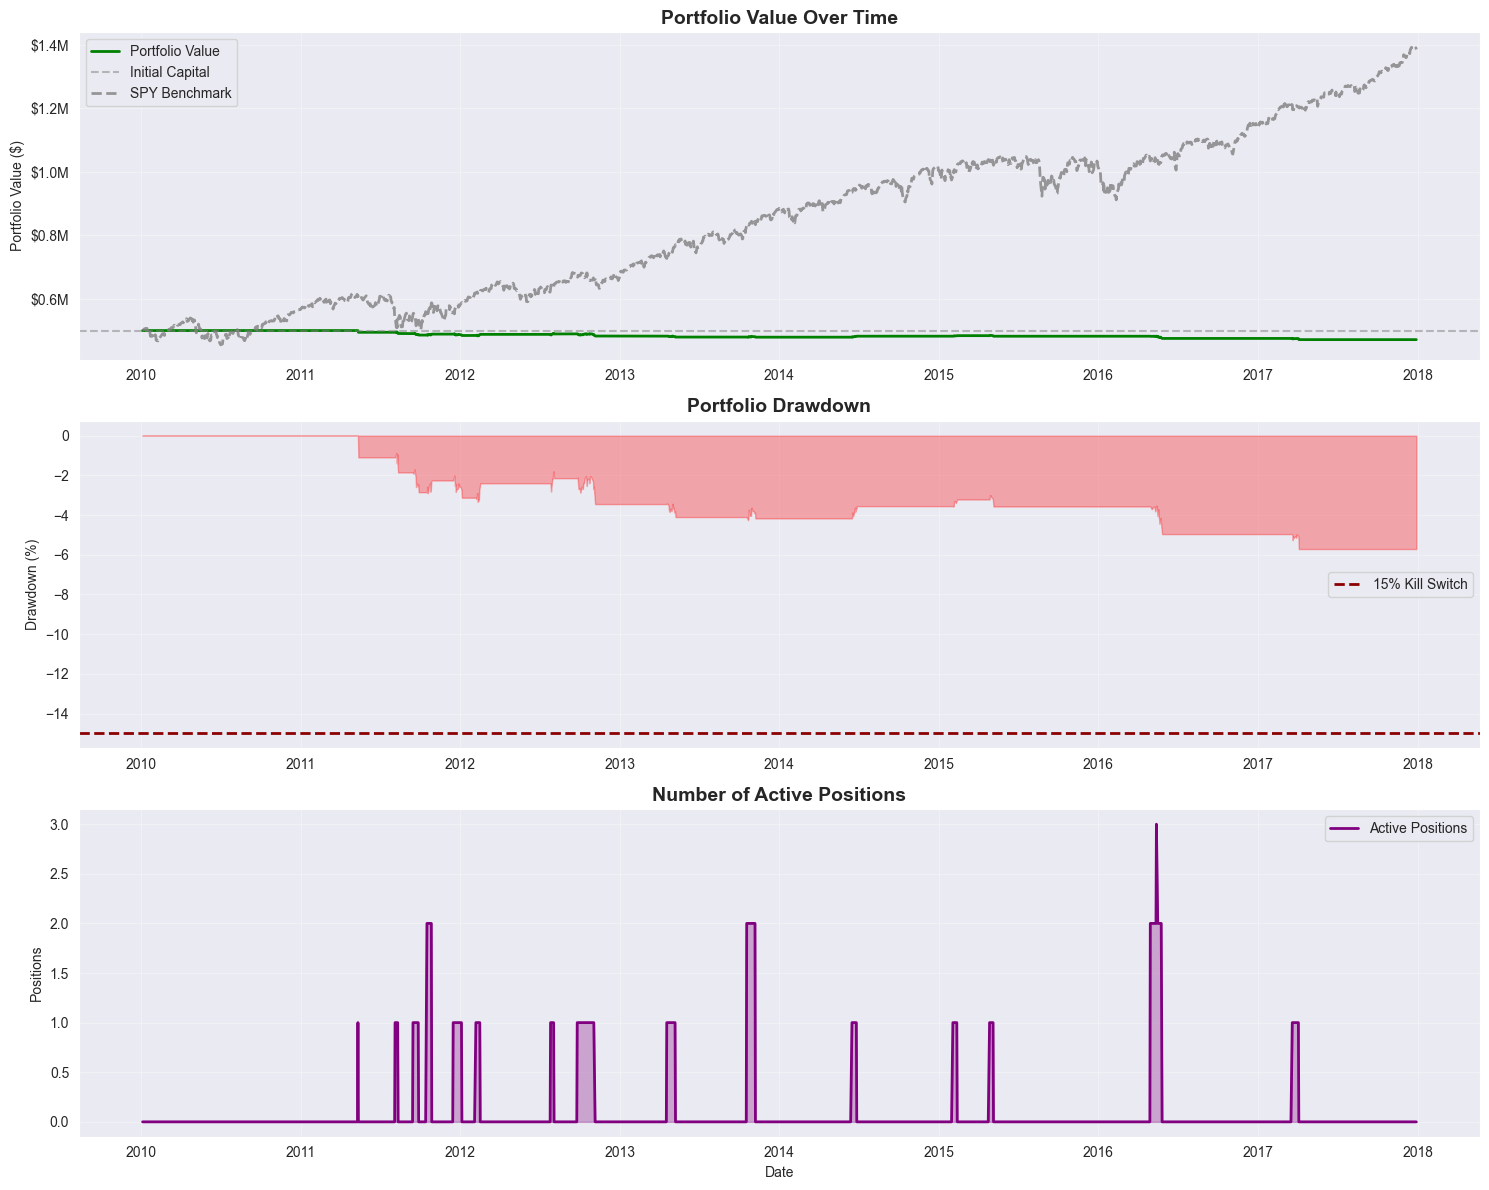


PORTFOLIO PERFORMANCE SUMMARY

Metric                                     Strategy      Benchmark (SPY)
------------------------------ -------------------- --------------------

Returns:
Total Return                                 -5.71%              176.99%
Annualized Return                            -0.73%               13.60%
Final Portfolio Value          $            471,442 $          1,384,971

Risk Metrics:
Annualized Volatility                         1.19%               14.63%
Maximum Drawdown                             -5.71%              -18.61%

Risk-Adjusted Returns:
Sharpe Ratio                                  -0.61                 0.93
Sortino Ratio                                 -0.23                  N/A
Calmar Ratio                                  -0.13                  N/A

Trading Statistics:
Total Trades                                     19                  N/A
Total Events                                   4210                  N/A
Win Rate              

In [167]:
# ============================================================================
# FINAL NOTEBOOK CELL
# ============================================================================

# Define parameters for the backtest
start_date = "2010-01-01"  # We will change this
end_date = "2017-12-31"    # We will change this
stock_list = SPY_STOCKS    # We will also change this

# Other parameters
other_variables = {
    'initial_capital': 500000.0,
    'transaction_cost': 0.0,
    'leverage': 0.0,
    'max_positions': 10,
    'max_position_size': 0.1,
    'stop_loss_pct': 0.05,
    'trailing_stop_pct': 0.015,
    'max_portfolio_drawdown': 0.15,
}

# One function that runs the backtest
results = run_backtest(start_date=start_date, 
                       end_date=end_date,
                       stock_list=stock_list,
                       benchmark_ticker='SPY',
                       **other_variables)




In [168]:

# ============================================================================
# SPY BENCHMARK CALCULATOR
# ============================================================================

def calculate_spy_benchmark(start_date: str,
                        end_date: str,
                        initial_capital: float = 500000.0,
                            symbol: str = "SPY") -> Dict:
    """Buy the SPY benchmark at the start date and hold through the test window."""
    print(f"{'='*60}")
    print(f"CALCULATING {symbol} BENCHMARK")
    print(f"{'='*60}")

    ticker = yf.Ticker(symbol)
    df = ticker.history(start=start_date, end=end_date)
    if df.empty or len(df) < 2:
        raise ValueError(f"Not enough {symbol} data to build benchmark")

    df = df[['Close']].copy()
    df.index = pd.to_datetime(df.index)

    shares = initial_capital / df['Close'].iloc[0]
    df['portfolio_value'] = shares * df['Close']
    df['daily_return'] = df['portfolio_value'].pct_change().fillna(0)
    df['cumulative_return'] = (df['portfolio_value'] / initial_capital) - 1
    df['peak'] = df['portfolio_value'].cummax()
    df['drawdown'] = (df['portfolio_value'] - df['peak']) / df['peak']

    total_value = df['portfolio_value'].iloc[-1]
    total_return = (total_value / initial_capital) - 1
    n_days = len(df)
    n_years = n_days / 252
    annualized_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0.0

    daily_vol = df['daily_return'].std()
    annualized_vol = daily_vol * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0.0

    downside_returns = df[df['daily_return'] < 0]['daily_return']
    downside_std = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0.0
    sortino_ratio = annualized_return / downside_std if downside_std > 0 else 0.0

    max_drawdown = df['drawdown'].min()
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0.0

    print(f"✅ {symbol} benchmark calculated")
    print(f"Final Value: ${total_value:,.2f}")
    print(f"Total Return: {total_return*100:.2f}%")

    return {
        'symbol': symbol,
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'final_value': total_value,
        'daily_data': df
    }

print("✅ SPY benchmark function defined!")


✅ SPY benchmark function defined!


In [169]:

def compare_strategy_vs_benchmark(strategy_metrics: Dict,
                                    spy_metrics: Dict,
                                    start_date: str,
                                    end_date: str):
    """Compare strategy performance vs the SPY benchmark."""
    benchmark_name = f"{spy_metrics.get('symbol', 'SPY')} Benchmark"

    strategy_data = strategy_metrics['daily_data']
    spy_data = spy_metrics['daily_data']

    fig, axes = plt.subplots(3, 2, figsize=(18, 14))

    axes[0, 0].plot(strategy_data.index, strategy_data['portfolio_value'],
                    label='Strategy', color='green', linewidth=2)
    axes[0, 0].plot(spy_data.index, spy_data['portfolio_value'],
                    label=benchmark_name, color='blue', linewidth=2, alpha=0.7)

    axes[0, 0].axhline(y=strategy_metrics['overall']['final_value'], color='green',
                        linestyle='--', alpha=0.3)
    axes[0, 0].axhline(y=spy_metrics['final_value'], color='blue',
                        linestyle='--', alpha=0.3)

    axes[0, 0].set_title(f'Portfolio Value: Strategy vs {benchmark_name}',
                            fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Portfolio Value ($)')
    axes[0, 0].legend(loc='best')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

    axes[0, 1].plot(strategy_data.index, strategy_data['cumulative_return'] * 100,
                    label='Strategy', color='green', linewidth=2)
    axes[0, 1].plot(spy_data.index, spy_data['cumulative_return'] * 100,
                    label=benchmark_name, color='blue', linewidth=2, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[0, 1].set_title('Cumulative Return (%)', fontsize=14, fontweight='bold')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].legend(loc='best')
    axes[0, 1].grid(True, alpha=0.3)

    axes[1, 0].plot(strategy_data.index, strategy_data['drawdown'] * 100,
                    label='Strategy', color='red', linewidth=2)
    axes[1, 0].plot(spy_data.index, spy_data['drawdown'] * 100,
                    label=benchmark_name, color='purple', linewidth=2, alpha=0.7)
    axes[1, 0].set_title('Drawdown (%)', fontsize=14, fontweight='bold')
    axes[1, 0].set_ylabel('Drawdown (%)')
    axes[1, 0].legend(loc='best')
    axes[1, 0].grid(True, alpha=0.3)

    strategy_rolling_sharpe = (strategy_data['daily_return'].rolling(252).mean() * 252) /(strategy_data['daily_return'].rolling(252).std() * np.sqrt(252))
    spy_rolling_sharpe = (spy_data['daily_return'].rolling(252).mean() * 252) / (spy_data['daily_return'].rolling(252).std() * np.sqrt(252))

    axes[1, 1].plot(strategy_data.index, strategy_rolling_sharpe,
                    label='Strategy', color='green', linewidth=2)
    axes[1, 1].plot(spy_data.index, spy_rolling_sharpe,
                    label=benchmark_name, color='blue', linewidth=2, alpha=0.7)
    axes[1, 1].axhline(y=1.0, color='red', linestyle='--', linewidth=1, label='Sharpe = 1.0')
    axes[1, 1].set_title('Rolling Sharpe Ratio (1-Year)', fontsize=14, fontweight='bold')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].legend(loc='best')
    axes[1, 1].grid(True, alpha=0.3)

    metrics_comparison = {
        'Total Return (%)': [strategy_metrics['overall']['total_return'] * 100,
                                spy_metrics['total_return'] * 100],
        'Ann. Return (%)': [strategy_metrics['overall']['annualized_return'] * 100,
                            spy_metrics['annualized_return'] * 100],
        'Sharpe Ratio': [strategy_metrics['overall']['sharpe_ratio'],
                            spy_metrics['sharpe_ratio']],
        'Sortino Ratio': [strategy_metrics['overall']['sortino_ratio'],
                            spy_metrics['sortino_ratio']],
        'Calmar Ratio': [strategy_metrics['overall']['calmar_ratio'],
                            spy_metrics['calmar_ratio']]
    }

    x = np.arange(len(metrics_comparison))
    width = 0.35
    strategy_values = [v[0] for v in metrics_comparison.values()]
    benchmark_values = [v[1] for v in metrics_comparison.values()]

    axes[2, 0].bar(x - width/2, strategy_values, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 0].bar(x + width/2, benchmark_values, width, label=benchmark_name, color='blue', alpha=0.7)
    axes[2, 0].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
    axes[2, 0].set_ylabel('Value')
    axes[2, 0].set_xticks(x)
    axes[2, 0].set_xticklabels(metrics_comparison.keys(), rotation=45, ha='right')
    axes[2, 0].legend(loc='best')
    axes[2, 0].grid(True, alpha=0.3, axis='y')
    axes[2, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

    risk_comparison = {
        'Ann. Vol (%)': [strategy_metrics['overall']['annualized_volatility'] * 100,
                            spy_metrics['annualized_volatility'] * 100],
        'Max DD (%)': [strategy_metrics['overall']['max_drawdown'] * 100,
                        spy_metrics['max_drawdown'] * 100]
    }

    x_risk = np.arange(len(risk_comparison))
    strategy_risk = [v[0] for v in risk_comparison.values()]
    benchmark_risk = [v[1] for v in risk_comparison.values()]

    axes[2, 1].bar(x_risk - width/2, strategy_risk, width, label='Strategy', color='green', alpha=0.7)
    axes[2, 1].bar(x_risk + width/2, benchmark_risk, width, label=benchmark_name, color='blue', alpha=0.7)
    axes[2, 1].set_title('Risk Metrics Comparison (Lower is Better)', fontsize=14, fontweight='bold')
    axes[2, 1].set_ylabel('Value (%)')
    axes[2, 1].set_xticks(x_risk)
    axes[2, 1].set_xticklabels(risk_comparison.keys())
    axes[2, 1].legend(loc='best')
    axes[2, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print(f"{'='*80}")
    print(f"STRATEGY VS {benchmark_name.upper()} COMPARISON")
    print(f"Period: {start_date} to {end_date}")
    print(f"{'='*80}")

    comparison_df = pd.DataFrame({
        'Strategy': {
            'Total Return': f"{strategy_metrics['overall']['total_return']*100:.2f}%",
            'Annualized Return': f"{strategy_metrics['overall']['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{strategy_metrics['overall']['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{strategy_metrics['overall']['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{strategy_metrics['overall']['sortino_ratio']:.2f}",
            'Max Drawdown': f"{strategy_metrics['overall']['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{strategy_metrics['overall']['calmar_ratio']:.2f}",
            'Final Value': f"${strategy_metrics['overall']['final_value']:,.0f}"
        },
        benchmark_name: {
            'Total Return': f"{spy_metrics['total_return']*100:.2f}%",
            'Annualized Return': f"{spy_metrics['annualized_return']*100:.2f}%",
            'Annualized Volatility': f"{spy_metrics['annualized_volatility']*100:.2f}%",
            'Sharpe Ratio': f"{spy_metrics['sharpe_ratio']:.2f}",
            'Sortino Ratio': f"{spy_metrics['sortino_ratio']:.2f}",
            'Max Drawdown': f"{spy_metrics['max_drawdown']*100:.2f}%",
            'Calmar Ratio': f"{spy_metrics['calmar_ratio']:.2f}",
            'Final Value': f"${spy_metrics['final_value']:,.0f}"
        }
    })

    comparison_df['Difference'] = ''
    for metric in comparison_df.index:
        if metric == 'Final Value':
            diff = strategy_metrics['overall']['final_value'] - spy_metrics['final_value']
            comparison_df.loc[metric, 'Difference'] = f"${diff:,.0f}"
        elif 'Ratio' in metric:
            metric_key = metric.lower().replace(' ', '_')
            diff = strategy_metrics['overall'][metric_key] - spy_metrics[metric_key]
            comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}"
        else:
            metric_key = metric.lower().replace(' ', '_')
            diff = (strategy_metrics['overall'][metric_key] - spy_metrics[metric_key])
            if 'return' in metric_key or 'volatility' in metric_key or 'drawdown' in metric_key:
                diff *= 100
            comparison_df.loc[metric, 'Difference'] = f"{diff:+.2f}{'%' if '%' in metric else ''}"

    print(comparison_df.to_string())

    print(f"{'='*80}")
    print("WINNER DETERMINATION")
    print(f"{'='*80}")

    strategy_wins = 0
    benchmark_wins = 0

    if strategy_metrics['overall']['total_return'] > spy_metrics['total_return']:
        print("✅ Strategy has HIGHER total return")
        strategy_wins += 1
    else:
        print(f"❌ {benchmark_name} has HIGHER total return")
        benchmark_wins += 1

    if strategy_metrics['overall']['sharpe_ratio'] > spy_metrics['sharpe_ratio']:
        print("✅ Strategy has BETTER risk-adjusted returns (Sharpe)")
        strategy_wins += 1
    else:
        print(f"❌ {benchmark_name} has BETTER risk-adjusted returns (Sharpe)")
        benchmark_wins += 1

    if strategy_metrics['overall']['max_drawdown'] > spy_metrics['max_drawdown']:
        print("✅ Strategy has LOWER maximum drawdown")
        strategy_wins += 1
    else:
        print(f"❌ {benchmark_name} has LOWER maximum drawdown")
        benchmark_wins += 1

    if strategy_metrics['overall']['annualized_volatility'] < spy_metrics['annualized_volatility']:
        print("✅ Strategy has LOWER volatility")
        strategy_wins += 1
    else:
        print(f"❌ {benchmark_name} has LOWER volatility")
        benchmark_wins += 1

    print(f"{'='*80}")
    if strategy_wins > benchmark_wins:
        print(f"🏆 STRATEGY WINS: {strategy_wins} vs {benchmark_wins}")
        print("✅ Your event-driven strategy OUTPERFORMS the benchmark!")
    elif benchmark_wins > strategy_wins:
        print(f"🏆 {benchmark_name.upper()} WINS: {benchmark_wins} vs {strategy_wins}")
        print(f"❌ {benchmark_name} OUTPERFORMS your strategy")
    else:
        print(f"🤝 TIE: {strategy_wins} vs {benchmark_wins}")
        print("⚖️  Both strategies perform equally")
    print(f"{'='*80}")


CALCULATING SPY BENCHMARK
✅ SPY benchmark calculated
Final Value: $1,384,971.10
Total Return: 176.99%


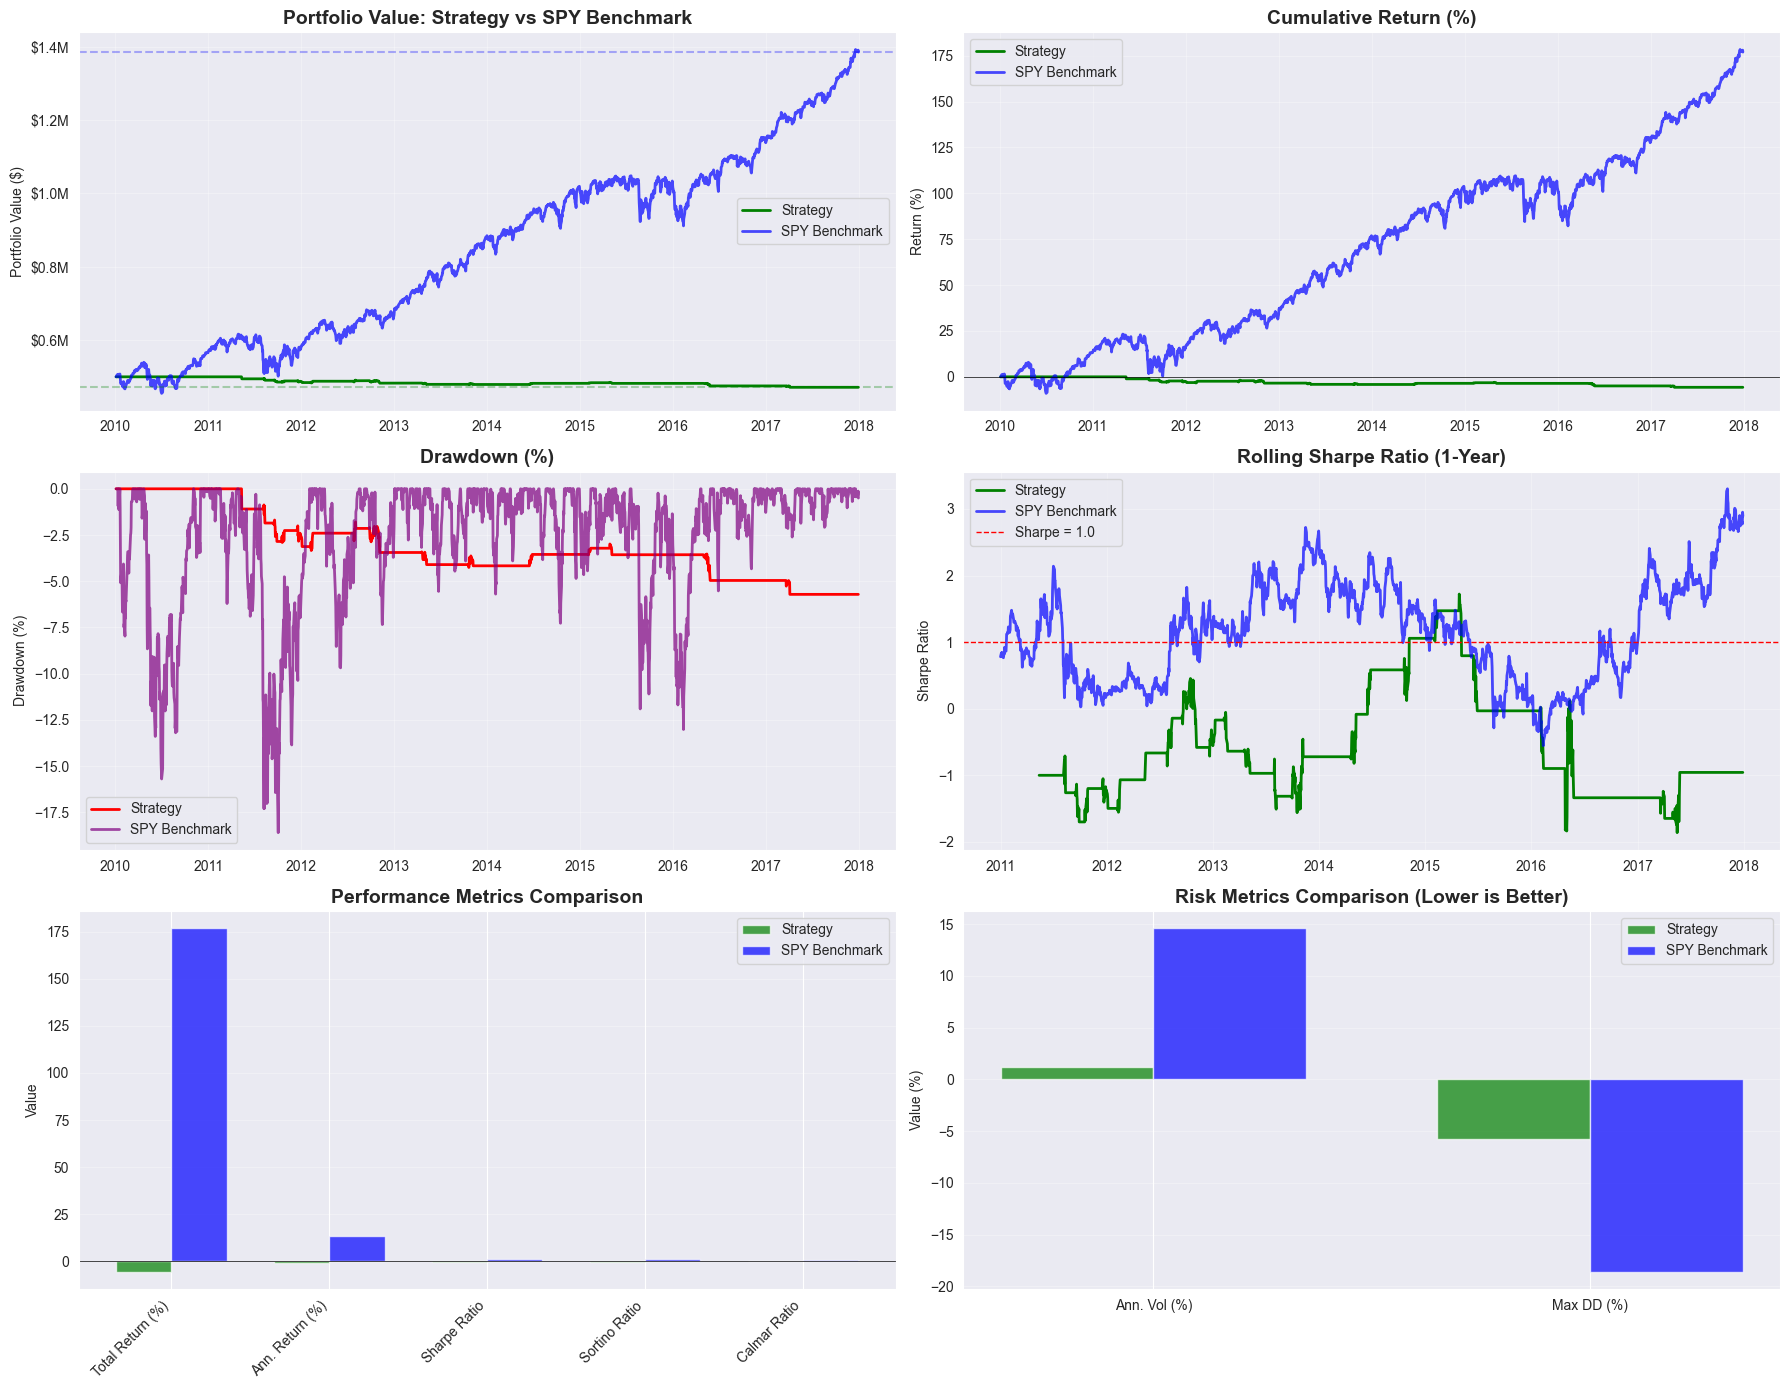

STRATEGY VS SPY BENCHMARK COMPARISON
Period: 2010-01-01 to 2017-12-31
                       Strategy SPY Benchmark Difference
Total Return             -5.71%       176.99%    -182.71
Annualized Return        -0.73%        13.60%     -14.34
Annualized Volatility     1.19%        14.63%     -13.43
Sharpe Ratio              -0.61          0.93      -1.54
Sortino Ratio             -0.23          1.18      -1.40
Max Drawdown             -5.71%       -18.61%     +12.89
Calmar Ratio              -0.13          0.73      -0.86
Final Value            $471,442    $1,384,971  $-913,529
WINNER DETERMINATION
❌ SPY Benchmark has HIGHER total return
❌ SPY Benchmark has BETTER risk-adjusted returns (Sharpe)
✅ Strategy has LOWER maximum drawdown
✅ Strategy has LOWER volatility
🤝 TIE: 2 vs 2
⚖️  Both strategies perform equally


In [170]:

# ============================================================================
# RUN STRATEGY VS SPY BENCHMARK COMPARISON
# ============================================================================

# Assuming you have already run your strategy backtest and stored results in 'results'
# If not, run your backtest first:
# results = run_backtest(start_date=start_date, end_date=end_date, stock_list=stock_list, **other_variables)

# Calculate SPY benchmark
spy_results = calculate_spy_benchmark(
    start_date=start_date,
    end_date=end_date,
    initial_capital=other_variables['initial_capital']
)

# Compare Strategy vs SPY benchmark
compare_strategy_vs_benchmark(
    strategy_metrics=results['metrics'],
    spy_metrics=spy_results,
    start_date=start_date,
    end_date=end_date
)


In [171]:
#add monte carlo
# ============================================================================
# MONTE CARLO SIMULATION: PARAMETER UNCERTAINTY
# ============================================================================

def monte_carlo_parameter_test(stock_data: Dict[str, pd.DataFrame], vix_data: pd.DataFrame,
                               base_config: StrategyConfig,
                               n_simulations: int = 500) -> pd.DataFrame:
    """
    Test strategy with random parameter variations
    
    Randomly samples parameters from reasonable ranges to test robustness
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: PARAMETER UNCERTAINTY TEST ({n_simulations} runs)")
    print(f"{'='*60}\n")
    
    # Define parameter ranges
    param_ranges = {
        'ema_fast': list(range(10, 31, 5)),           # [10, 15, 20, 25, 30]
        'ema_slow': list(range(30, 71, 10)),          # [30, 40, 50, 60, 70]
        # 'rsi_period': list(range(10, 21, 2)),         # [10, 12, 14, 16, 18, 20]
        # 'adx_threshold': np.arange(15, 36, 5),        # [15, 20, 25, 30, 35]
        # 'rsi_long_threshold': np.arange(45, 61, 5),   # [45, 50, 55, 60]
        'stop_loss_pct': np.arange(0.015, 0.031, 0.005),     # [1.5%, 2%, 2.5%, 3%]
        'trailing_stop_pct': np.arange(0.01, 0.026, 0.005),  # [1%, 1.5%, 2%, 2.5%]
        'max_positions': list(range(5, 16, 5))        # [5, 10, 15]
    }
    
    results = []
    failed_count = 0
    
    for i in tqdm(range(n_simulations), desc="Running parameter variations"):
        # Random parameter selection
        test_config = StrategyConfig(
            ema_fast=np.random.choice(param_ranges['ema_fast']),
            ema_slow=np.random.choice(param_ranges['ema_slow']),
            # rsi_period=np.random.choice(param_ranges['rsi_period']),
            # adx_threshold=np.random.choice(param_ranges['adx_threshold']),
            # rsi_long_threshold=np.random.choice(param_ranges['rsi_long_threshold']),
            stop_loss_pct=np.random.choice(param_ranges['stop_loss_pct']),
            trailing_stop_pct=np.random.choice(param_ranges['trailing_stop_pct']),
            max_positions=np.random.choice(param_ranges['max_positions']),
            initial_capital=base_config.initial_capital,
            transaction_cost=base_config.transaction_cost,
            leverage=base_config.leverage,
            train_start=base_config.train_start,
            train_end=base_config.train_end
        )
        
        # Ensure fast < slow
        if test_config.ema_fast >= test_config.ema_slow:
            failed_count += 1
            continue
        
        try:
            # Run backtest with new parameters
            backtester = PortfolioBacktester(test_config, stock_data, vix_data)
            backtester.run()
            
            metrics = calculate_portfolio_metrics(backtester)
            # --- FIX: Access metrics from the 'overall' sub-dictionary ---
            if 'overall' not in metrics:
                failed_count += 1
                continue
            n = metrics['overall']
            
            results.append({
                'run': i,
                'ema_fast': test_config.ema_fast,
                'ema_slow': test_config.ema_slow,
                # 'adx_threshold': test_config.adx_threshold,
                'stop_loss_pct': test_config.stop_loss_pct,
                'max_positions': test_config.max_positions,
                'total_return': n['total_return'],
                'annualized_return': n['annualized_return'],
                'sharpe_ratio': n['sharpe_ratio'],
                'sortino_ratio': n['sortino_ratio'],
                'max_drawdown': n['max_drawdown'],
                'calmar_ratio': n['calmar_ratio'],
                'win_rate': n['win_rate'],
                'total_trades': n['total_trades']
            })
            
        except Exception as e:
            failed_count += 1
            continue
    
    results_df = pd.DataFrame(results)
    
    print(f"\n✅ Completed: {len(results_df)} successful, {failed_count} failed")
    print(f"\nParameter Uncertainty Results:")
    print(f"  Mean Sharpe Ratio: {results_df['sharpe_ratio'].mean():.2f}")
    print(f"  Median Sharpe Ratio: {results_df['sharpe_ratio'].median():.2f}")
    print(f"  Std Dev Sharpe Ratio: {results_df['sharpe_ratio'].std():.2f}")
    print(f"  % Profitable Runs: {(results_df['total_return'] > 0).sum() / len(results_df) * 100:.1f}%")
    print(f"  % Sharpe > 1.0: {(results_df['sharpe_ratio'] > 1.0).sum() / len(results_df) * 100:.1f}%")
    
    return results_df

print("✅ Monte Carlo parameter test function defined!")

✅ Monte Carlo parameter test function defined!


In [172]:
# ============================================================================
# MONTE CARLO SIMULATION: BOOTSTRAP RESAMPLING
# ============================================================================

def monte_carlo_bootstrap_test(strategy_results: pd.DataFrame,
                               n_samples: int = 1000) -> pd.DataFrame:
    """
    Bootstrap resampling of daily returns to test statistical significance
    
    Resamples with replacement to generate confidence intervals
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: BOOTSTRAP RESAMPLING ({n_samples} samples)")
    print(f"{'='*60}\n")
    
    # Get strategy returns
    daily_returns = strategy_results['daily_return'].dropna()
    n_days = len(daily_returns)
    
    if n_days < 10:
        print("⚠️ Insufficient data for bootstrap")
        return pd.DataFrame()
    
    bootstrap_results = []
    
    for i in tqdm(range(n_samples), desc="Bootstrap resampling"):
        # Resample with replacement
        resampled_returns = np.random.choice(daily_returns, size=n_days, replace=True)
        
        # Calculate metrics
        total_return = np.exp(resampled_returns.sum()) - 1
        annual_return = (1 + total_return) ** (252 / n_days) - 1
        annual_vol = resampled_returns.std() * np.sqrt(252)
        sharpe = annual_return / annual_vol if annual_vol > 0 else 0
        
        # Downside deviation
        downside = resampled_returns[resampled_returns < 0]
        downside_std = downside.std() * np.sqrt(252) if len(downside) > 0 else 0.0001
        sortino = annual_return / downside_std if downside_std > 0 else 0
        
        bootstrap_results.append({
            'sample': i,
            'total_return': total_return,
            'annualized_return': annual_return,
            'annualized_volatility': annual_vol,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino
        })
    
    bootstrap_df = pd.DataFrame(bootstrap_results)
    
    print(f"\n✅ Bootstrap Resampling Results:")
    print(f"  Mean Return: {bootstrap_df['annualized_return'].mean()*100:.2f}%")
    print(f"  95% CI Return: [{bootstrap_df['annualized_return'].quantile(0.025)*100:.2f}%, "
          f"{bootstrap_df['annualized_return'].quantile(0.975)*100:.2f}%]")
    print(f"  Mean Sharpe: {bootstrap_df['sharpe_ratio'].mean():.2f}")
    print(f"  95% CI Sharpe: [{bootstrap_df['sharpe_ratio'].quantile(0.025):.2f}, "
          f"{bootstrap_df['sharpe_ratio'].quantile(0.975):.2f}]")
    print(f"  Probability of Positive Return: {(bootstrap_df['annualized_return'] > 0).sum() / len(bootstrap_df) * 100:.1f}%")
    
    return bootstrap_df

print("✅ Monte Carlo bootstrap function defined!")

✅ Monte Carlo bootstrap function defined!


In [173]:
# ============================================================================
# MONTE CARLO SIMULATION: SYNTHETIC PRICE PATHS
# ============================================================================

def monte_carlo_synthetic_paths(stock_data: Dict[str, pd.DataFrame], # <-- ADDED
                                vix_data: pd.DataFrame,           # <-- ADDED
                                base_config: StrategyConfig,
                                n_paths: int = 100) -> pd.DataFrame:
    """
    Test strategy on synthetic price paths using Geometric Brownian Motion
    
    Generates random price paths with same statistical properties as real data
    """
    print(f"\n{'='*60}")
    print(f"MONTE CARLO: SYNTHETIC PRICE PATHS ({n_paths} paths)")
    print(f"{'='*60}\n")
    
    # Get trading dates and number of days from VIX data
    trading_dates = vix_data.index
    n_days = len(trading_dates)

    print("Estimating parameters from existing data...")
    stock_params = {}
    for symbol, df in stock_data.items():
        # Ensure df index matches vix index
        df = df.reindex(trading_dates).fillna(method='ffill')
        if df.isnull().any().any():
            continue # Skip if still has NaNs
            
        returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()
        if returns.empty:
            continue
            
        stock_params[symbol] = {
            'mu': returns.mean(),
            'sigma': returns.std(),
            'initial_price': df['Close'].iloc[0],
        }
    
    if len(stock_params) == 0:
        print("⚠️ No valid stock data to estimate parameters")
        return pd.DataFrame()

    print(f"Generating paths for {len(stock_params)} stocks...")
    
    # Run simulations
    synthetic_results = []
    failed_count = 0
    
    for path_num in tqdm(range(n_paths), desc="Generating synthetic paths"):
        # Generate synthetic data for each stock
        synthetic_stock_data = {}
        
        for symbol, params in stock_params.items():
            # Geometric Brownian Motion
            dt = 1/252 # Assuming 252 trading days
            price_path = [params['initial_price']]
            
            for _ in range(n_days - 1):
                drift = (params['mu'] - 0.5 * params['sigma']**2) * dt
                diffusion = params['sigma'] * np.sqrt(dt) * np.random.normal()
                price = price_path[-1] * np.exp(drift + diffusion)
                price_path.append(price)
            
            # Create synthetic dataframe
            synthetic_df = pd.DataFrame({
                'Close': price_path,
                # Add High/Low/Volume for indicators
                'High': [p * (1 + abs(np.random.normal(0, 0.01))) for p in price_path],
                'Low': [p * (1 - abs(np.random.normal(0, 0.01))) for p in price_path],
                'Volume': [np.random.randint(1e6, 1e7) for _ in price_path]
            }, index=trading_dates) # <-- Use VIX index
            
            # Calculate indicators
            try:
                df_with_indicators = calculate_indicators(synthetic_df, base_config)
                synthetic_stock_data[symbol] = df_with_indicators
            except:
                continue
        
        if len(synthetic_stock_data) < 1:
            failed_count += 1
            continue
        
        # Run backtest on synthetic data
        try:
            # --- FIX: Pass 'vix_data' to the backtester ---
            backtester = PortfolioBacktester(base_config, synthetic_stock_data, vix_data) # <-- ADDED
            backtester.run()
            
            metrics = calculate_portfolio_metrics(backtester)
            
            # --- FIX: Access metrics from the 'overall' sub-dictionary ---
            if 'overall' not in metrics:
                failed_count += 1
                continue
            
            m = metrics['overall'] # Helper variable
            
            synthetic_results.append({
                'path': path_num,
                'total_return': m['total_return'],           # <-- FIXED
                'annualized_return': m['annualized_return'], # <-- FIXED
                'sharpe_ratio': m['sharpe_ratio'],           # <-- FIXED
                'sortino_ratio': m['sortino_ratio'],         # <-- FIXED
                'max_drawdown': m['max_drawdown'],         # <-- FIXED
                'calmar_ratio': m['calmar_ratio'],           # <-- FIXED
                'total_trades': m['total_trades']          # <-- FIXED
            })
            
        except Exception as e:
            failed_count += 1
            continue
    
    synthetic_df = pd.DataFrame(synthetic_results)

    
    if len(synthetic_df) > 0:
        print(f"\n✅ Completed: {len(synthetic_df)} successful, {failed_count} failed")
        print(f"\nSynthetic Paths Results:")
        print(f"  Mean Sharpe Ratio: {synthetic_df['sharpe_ratio'].mean():.2f}")
        print(f"  % Profitable Runs: {(synthetic_df['total_return'] > 0).sum() / len(synthetic_df) * 100:.1f}%")
        print(f"  % Sharpe > 1.0: {(synthetic_df['sharpe_ratio'] > 1.0).sum() / len(synthetic_df) * 100:.1f}%")
    else:
        print("⚠️ All synthetic simulations failed")
    
    return synthetic_df

print("✅ Monte Carlo synthetic paths function defined!")

✅ Monte Carlo synthetic paths function defined!


In [174]:
# ============================================================================
# MONTE CARLO VISUALIZATION
# ============================================================================

def plot_monte_carlo_results(param_results: pd.DataFrame,
                             bootstrap_results: pd.DataFrame,
                             synthetic_results: pd.DataFrame,
                             actual_sharpe: float):
    """
    Visualize all Monte Carlo simulation results
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Parameter Test - Sharpe Distribution
    if len(param_results) > 0:
        axes[0, 0].hist(param_results['sharpe_ratio'], bins=30, color='blue', alpha=0.7, edgecolor='black')
        axes[0, 0].axvline(param_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["sharpe_ratio"].mean():.2f}')
        axes[0, 0].axvline(actual_sharpe, color='green', linestyle='--', 
                          linewidth=2, label=f'Actual: {actual_sharpe:.2f}')
        axes[0, 0].axvline(1.0, color='gray', linestyle=':', linewidth=1, label='Target: 1.0')
        axes[0, 0].set_title('Parameter Uncertainty: Sharpe Ratio', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('Sharpe Ratio')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Parameter Test - Returns Distribution
    if len(param_results) > 0:
        axes[0, 1].hist(param_results['total_return'] * 100, bins=30, color='green', alpha=0.7, edgecolor='black')
        axes[0, 1].axvline(param_results['total_return'].mean() * 100, color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["total_return"].mean()*100:.1f}%')
        axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1)
        axes[0, 1].set_title('Parameter Uncertainty: Total Return', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Total Return (%)')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Parameter Test - Max Drawdown
    if len(param_results) > 0:
        axes[0, 2].hist(param_results['max_drawdown'] * 100, bins=30, color='red', alpha=0.7, edgecolor='black')
        axes[0, 2].axvline(param_results['max_drawdown'].mean() * 100, color='blue', linestyle='--', 
                          linewidth=2, label=f'Mean: {param_results["max_drawdown"].mean()*100:.1f}%')
        axes[0, 2].axvline(-15, color='darkred', linestyle=':', linewidth=2, label='Kill Switch: -15%')
        axes[0, 2].set_title('Parameter Uncertainty: Max Drawdown', fontsize=12, fontweight='bold')
        axes[0, 2].set_xlabel('Max Drawdown (%)')
        axes[0, 2].set_ylabel('Frequency')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Bootstrap - Sharpe Distribution
    if len(bootstrap_results) > 0:
        axes[1, 0].hist(bootstrap_results['sharpe_ratio'], bins=30, color='purple', alpha=0.7, edgecolor='black')
        axes[1, 0].axvline(bootstrap_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {bootstrap_results["sharpe_ratio"].mean():.2f}')
        ci_lower = bootstrap_results['sharpe_ratio'].quantile(0.025)
        ci_upper = bootstrap_results['sharpe_ratio'].quantile(0.975)
        axes[1, 0].axvline(ci_lower, color='orange', linestyle=':', linewidth=1, label=f'95% CI')
        axes[1, 0].axvline(ci_upper, color='orange', linestyle=':', linewidth=1)
        axes[1, 0].set_title('Bootstrap: Sharpe Ratio Distribution', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Sharpe Ratio')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Bootstrap - Return Distribution
    if len(bootstrap_results) > 0:
        axes[1, 1].hist(bootstrap_results['annualized_return'] * 100, bins=30, color='cyan', alpha=0.7, edgecolor='black')
        axes[1, 1].axvline(bootstrap_results['annualized_return'].mean() * 100, color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {bootstrap_results["annualized_return"].mean()*100:.1f}%')
        axes[1, 1].axvline(0, color='black', linestyle='-', linewidth=1)
        axes[1, 1].set_title('Bootstrap: Annualized Return', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Annualized Return (%)')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Synthetic Paths - Sharpe Distribution
    if len(synthetic_results) > 0:
        axes[1, 2].hist(synthetic_results['sharpe_ratio'], bins=30, color='orange', alpha=0.7, edgecolor='black')
        axes[1, 2].axvline(synthetic_results['sharpe_ratio'].mean(), color='red', linestyle='--', 
                          linewidth=2, label=f'Mean: {synthetic_results["sharpe_ratio"].mean():.2f}')
        axes[1, 2].axvline(actual_sharpe, color='green', linestyle='--', 
                          linewidth=2, label=f'Actual: {actual_sharpe:.2f}')
        axes[1, 2].set_title('Synthetic Paths: Sharpe Ratio', fontsize=12, fontweight='bold')
        axes[1, 2].set_xlabel('Sharpe Ratio')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n{'='*80}")
    print("MONTE CARLO SUMMARY")
    print(f"{'='*80}\n")
    
    if len(param_results) > 0:
        print("Parameter Uncertainty Test:")
        print(f"  Simulations: {len(param_results)}")
        print(f"  Mean Sharpe: {param_results['sharpe_ratio'].mean():.2f} ± {param_results['sharpe_ratio'].std():.2f}")
        print(f"  Sharpe Range: [{param_results['sharpe_ratio'].min():.2f}, {param_results['sharpe_ratio'].max():.2f}]")
        print(f"  % Sharpe > Actual ({actual_sharpe:.2f}): {(param_results['sharpe_ratio'] > actual_sharpe).sum() / len(param_results) * 100:.1f}%")
        print()
    
    if len(bootstrap_results) > 0:
        print("Bootstrap Resampling:")
        print(f"  Samples: {len(bootstrap_results)}")
        print(f"  Mean Return: {bootstrap_results['annualized_return'].mean()*100:.2f}%")
        print(f"  95% CI: [{bootstrap_results['annualized_return'].quantile(0.025)*100:.2f}%, {bootstrap_results['annualized_return'].quantile(0.975)*100:.2f}%]")
        print(f"  P(Return > 0): {(bootstrap_results['annualized_return'] > 0).sum() / len(bootstrap_results) * 100:.1f}%")
        print()
    
    if len(synthetic_results) > 0:
        print("Synthetic Price Paths:")
        print(f"  Paths: {len(synthetic_results)}")
        print(f"  Mean Sharpe: {synthetic_results['sharpe_ratio'].mean():.2f}")
        print(f"  % Profitable: {(synthetic_results['total_return'] > 0).sum() / len(synthetic_results) * 100:.1f}%")
        print(f"  Strategy works on random data: {'✅ YES' if synthetic_results['sharpe_ratio'].mean() > 0 else '❌ NO'}")
    
    print(f"\n{'='*80}\n")

print("✅ Monte Carlo visualization function defined!")

✅ Monte Carlo visualization function defined!


✅ All variables extracted successfully
   Config: <class '__main__.StrategyConfig'>
   Stock data: 10 stocks
   VIX data: 2013 days
   Strategy Sharpe: -0.61

STARTING QUICK MONTE CARLO ANALYSIS (10 simulations each)

Test 1/3: Parameter Uncertainty (10 simulations)...

MONTE CARLO: PARAMETER UNCERTAINTY TEST (10 runs)



Running parameter variations:   0%|          | 0/10 [00:00<?, ?it/s]


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $480,502.87
Total Return: -3.90%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $480,502.87
Total Return: -3.90%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


SIMPLIFIED EVENT-DRIVEN PORTFOLIO BACKTEST
Period: 2010-01-01 to 2017-12-31
Universe: 10 stocks
Initial Capital: $500,000



Processing days:   0%|          | 0/2013 [00:00<?, ?it/s]


BACKTEST COMPLETE
Total Events: 4210
Total Trades: 19
Final Portfolio Value: $471,442.32
Total Return: -5.71%


✅ Completed: 10 successful, 0 failed

Parameter Uncertainty Results:
  Mean Sharpe Ratio: -0.61
  Median Sharpe Ratio: -0.61
  Std Dev Sharpe Ratio: 0.00
  % Profitable Runs: 0.0%
  % Sharpe > 1.0: 0.0%
✅ Parameter test complete: 10 successful runs

Test 2/3: Bootstrap Resampling (10 samples)...

MONTE CARLO: BOOTSTRAP RESAMPLING (10 samples)



Bootstrap resampling:   0%|          | 0/10 [00:00<?, ?it/s]


✅ Bootstrap Resampling Results:
  Mean Return: -0.76%
  95% CI Return: [-1.20%, -0.19%]
  Mean Sharpe: -0.64
  95% CI Sharpe: [-1.09, -0.15]
  Probability of Positive Return: 0.0%
✅ Bootstrap test complete: 10 samples

Test 3/3: Synthetic Price Paths (10 paths)...

MONTE CARLO: SYNTHETIC PRICE PATHS (10 paths)

Estimating parameters from existing data...
⚠️ No valid stock data to estimate parameters
✅ Synthetic test complete: 0 paths

Generating visualizations...


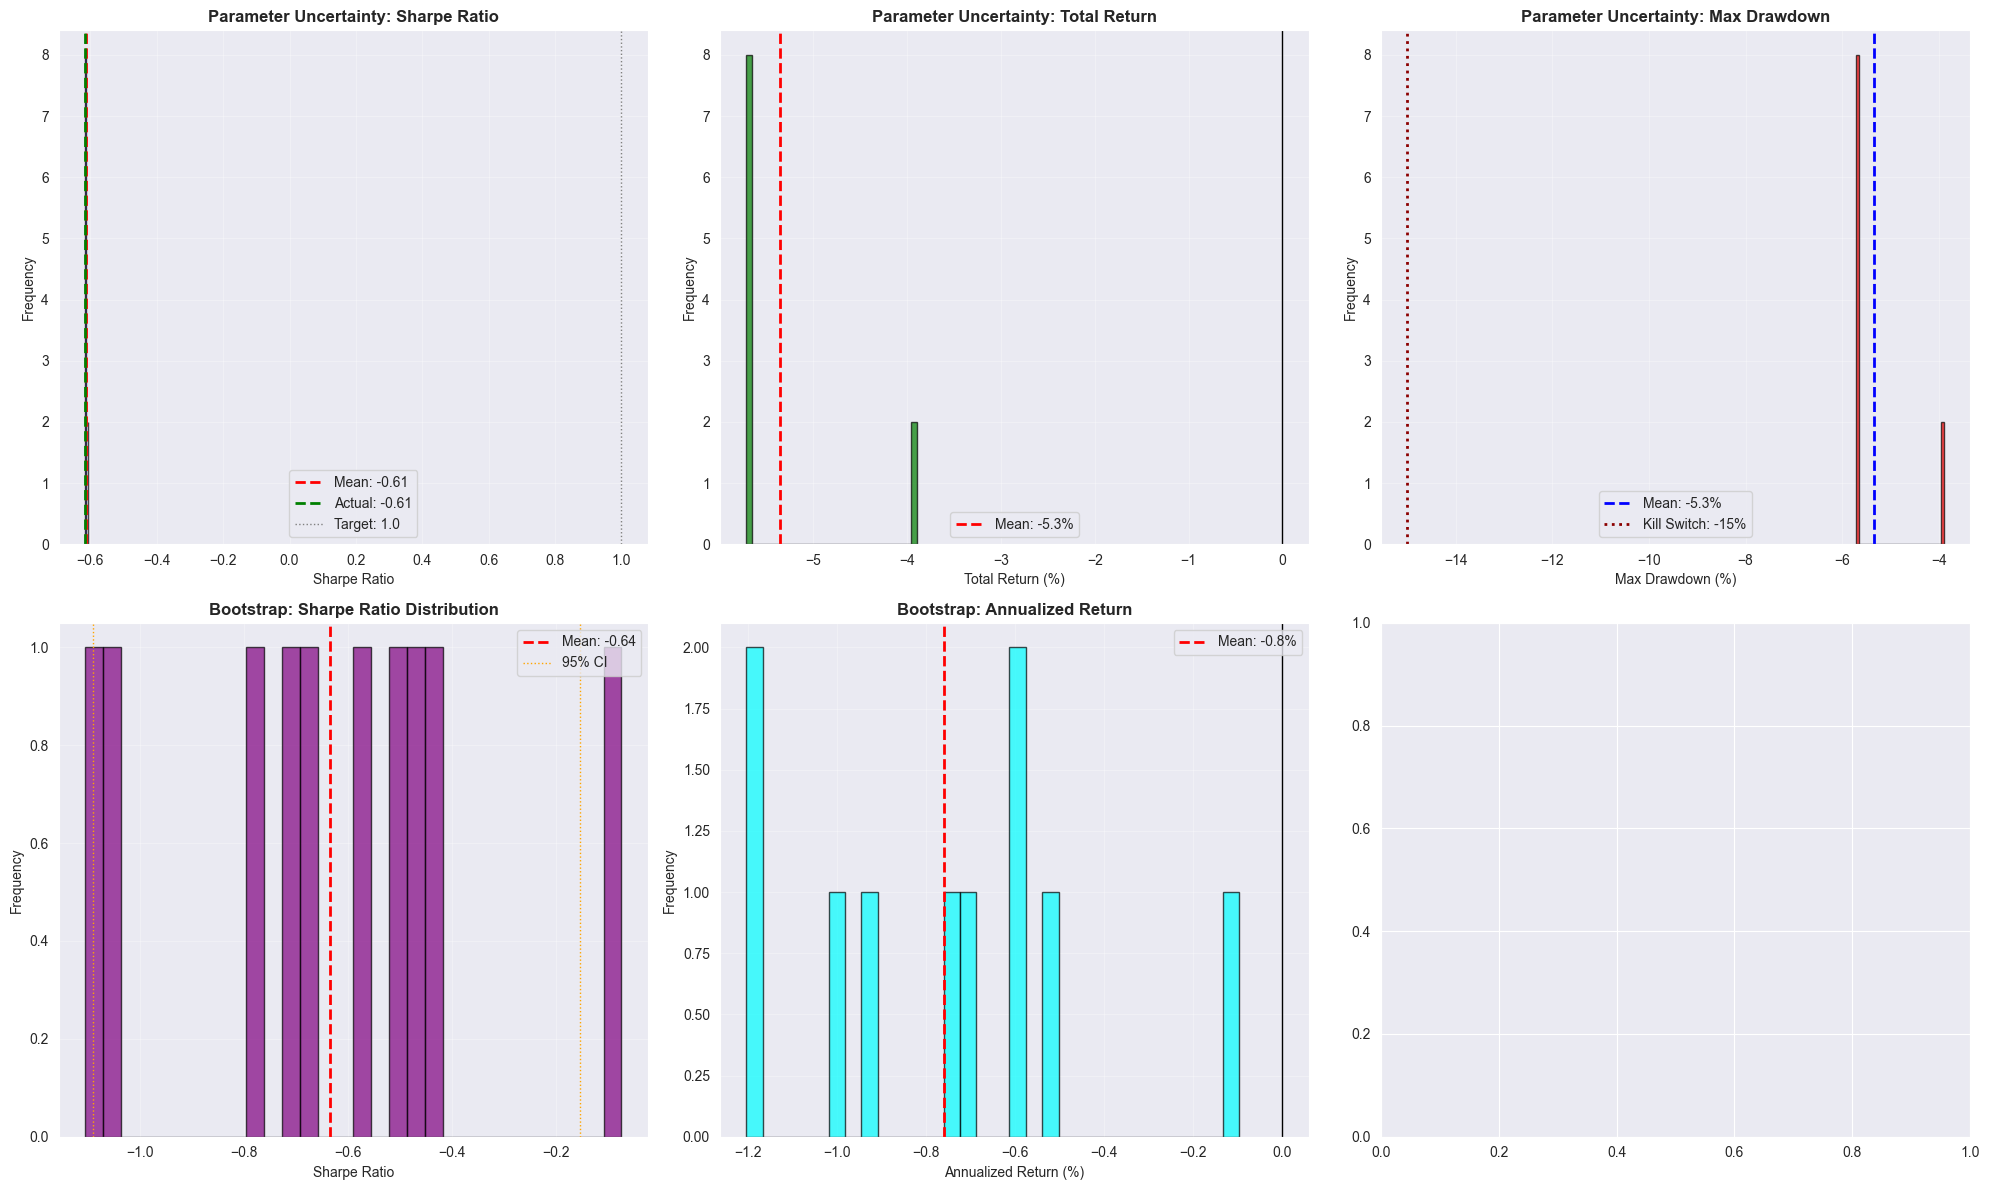


MONTE CARLO SUMMARY

Parameter Uncertainty Test:
  Simulations: 10
  Mean Sharpe: -0.61 ± 0.00
  Sharpe Range: [-0.61, -0.61]
  % Sharpe > Actual (-0.61): 20.0%

Bootstrap Resampling:
  Samples: 10
  Mean Return: -0.76%
  95% CI: [-1.20%, -0.19%]
  P(Return > 0): 0.0%



✅ Visualizations complete!

QUICK MONTE CARLO RESULTS

Parameter Test (n=10):
  Mean Sharpe: -0.61
  Range: [-0.61, -0.61]
  % Profitable: 0%

Bootstrap Test (n=10):
  Mean Return: -0.8%
  Sharpe Range: [-1.10, -0.07]




In [175]:
# ============================================================================
# QUICK MONTE CARLO ANALYSIS (10 SIMULATIONS FOR TESTING)
# ============================================================================

# Step 1: Verify results exist
if 'results' not in locals() and 'results' not in globals():
    raise ValueError("❌ Please run the backtest first: results = run_backtest(...)")

# Step 2: Extract required variables
try:
    config = results['config']
    backtester = results['backtester']
    stock_data = backtester.stock_data
    vix_data = backtester.vix_data # <--- ADD THIS
    strategy_metrics = results['metrics']
    
    print("✅ All variables extracted successfully")
    print(f"   Config: {type(config)}")
    print(f"   Stock data: {len(stock_data)} stocks")
    print(f"   VIX data: {len(vix_data)} days") # <--- ADD THIS
    # --- FIX: Access 'overall' dictionary ---
    print(f"   Strategy Sharpe: {strategy_metrics['overall']['sharpe_ratio']:.2f}")
    
except KeyError as e:
    raise ValueError(f"❌ Missing key in results: {e}. Did you fix the 'overall' nesting?")

# Step 3: Run Monte Carlo Tests with SMALL sample sizes
print(f"\n{'='*60}")
print("STARTING QUICK MONTE CARLO ANALYSIS (10 simulations each)")
print(f"{'='*60}\n")

# Test 1: Parameter Uncertainty (10 runs)
try:
    print("Test 1/3: Parameter Uncertainty (10 simulations)...")
    param_results = monte_carlo_parameter_test(
        stock_data=stock_data,
        vix_data=vix_data, # <--- ADD THIS
        base_config=config,
        n_simulations=10
    )
    print(f"✅ Parameter test complete: {len(param_results)} successful runs")
except Exception as e:
    print(f"❌ Parameter test failed: {e}")
    param_results = pd.DataFrame()

# Test 2: Bootstrap Resampling (10 samples)
# (This function is correct, no changes needed)
try:
    print("\nTest 2/3: Bootstrap Resampling (10 samples)...")
    bootstrap_results = monte_carlo_bootstrap_test(
        strategy_results=strategy_metrics['daily_data'],
        n_samples=10 
    )
    print(f"✅ Bootstrap test complete: {len(bootstrap_results)} samples")
except Exception as e:
    print(f"❌ Bootstrap test failed: {e}")
    bootstrap_results = pd.DataFrame()

# Test 3: Synthetic Paths (10 paths)
try:
    print("\nTest 3/3: Synthetic Price Paths (10 paths)...")
    # --- FIX: Updated function signature ---
    synthetic_results = monte_carlo_synthetic_paths(
        stock_data=stock_data, # <--- ADD THIS
        vix_data=vix_data,   # <--- ADD THIS
        base_config=config,
        n_paths=10
    )
    print(f"✅ Synthetic test complete: {len(synthetic_results)} paths")
except Exception as e:
    print(f"❌ Synthetic test failed: {e}")
    synthetic_results = pd.DataFrame()

# Step 4: Visualize Results
if len(param_results) > 0 or len(bootstrap_results) > 0 or len(synthetic_results) > 0:
    print("\nGenerating visualizations...")
    plot_monte_carlo_results(
        param_results=param_results,
        bootstrap_results=bootstrap_results,
        synthetic_results=synthetic_results,
        # --- FIX: Access 'overall' dictionary ---
        actual_sharpe=strategy_metrics['overall']['sharpe_ratio'] 
    )
    print("✅ Visualizations complete!")
else:
    print("⚠️ No results to visualize")

# Print quick summary
print(f"\n{'='*60}")
print("QUICK MONTE CARLO RESULTS")
print(f"{'='*60}")

if len(param_results) > 0:
    print(f"\nParameter Test (n={len(param_results)}):")
    print(f"  Mean Sharpe: {param_results['sharpe_ratio'].mean():.2f}")
    print(f"  Range: [{param_results['sharpe_ratio'].min():.2f}, {param_results['sharpe_ratio'].max():.2f}]")
    print(f"  % Profitable: {(param_results['total_return'] > 0).sum() / len(param_results) * 100:.0f}%")

if len(bootstrap_results) > 0:
    print(f"\nBootstrap Test (n={len(bootstrap_results)}):")
    print(f"  Mean Return: {bootstrap_results['annualized_return'].mean()*100:.1f}%")
    print(f"  Sharpe Range: [{bootstrap_results['sharpe_ratio'].min():.2f}, {bootstrap_results['sharpe_ratio'].max():.2f}]")

if len(synthetic_results) > 0:
    print(f"\nSynthetic Test (n={len(synthetic_results)}):")
    print(f"  Mean Sharpe: {synthetic_results['sharpe_ratio'].mean():.2f}")
    print(f"  % Profitable: {(synthetic_results['total_return'] > 0).sum() / len(synthetic_results) * 100:.0f}%")

print(f"\n{'='*60}\n")